In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.svm import SVR
from skopt import BayesSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance
from scipy.stats import normaltest
from sklearn.decomposition import PCA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from yellowbrick.regressor import residuals_plot
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
np.int = int

In [2]:
columnas_no_deseadas = ["row_id"]
df = pd.read_csv('train.csv', usecols= lambda x: x not in columnas_no_deseadas)

In [608]:
df.shape

(5237980, 16)

In [609]:
df['date_id'].max()

480

In [4]:
X_train = df[df['date_id'] < 240]
X_test = df[df['date_id'] >= 240]

Vamos a escoger la primera acción, ya que por limitaciones de hardware (RAM), no podemos trabajar con un dataset tan grande.

In [5]:
#np.random.seed(0)
#acciones_seleccionadas = np.random.choice(np.arange(200), size=50, replace=False)
#acciones_seleccionadas = np.sort(acciones_seleccionadas)
acciones_seleccionadas = list(range(1))

X_train = X_train.loc[X_train['stock_id'].isin(acciones_seleccionadas)]
X_test = X_test.loc[X_test['stock_id'].isin(acciones_seleccionadas)]

#acciones_mapping = {old_id: new_id for new_id, old_id in enumerate(acciones_seleccionadas)}

#X_train['stock_id'] = X_train['stock_id'].map(acciones_mapping)
#X_test['stock_id'] = X_test['stock_id'].map(acciones_mapping)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [612]:
X_train.head(10)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0
1,0,0,10,1299772.70,1,1.000026,15261106.63,NaN,NaN,0.999812,13996.50,1.000026,23519.16,0.999892,0.389814,1
2,0,0,20,1299772.70,1,0.999919,15261106.63,NaN,NaN,0.999812,4665.50,0.999919,12131.60,0.999842,4.220009,2
3,0,0,30,1299772.70,1,1.000133,15261106.63,NaN,NaN,1.000026,55998.00,1.000133,46203.30,1.000085,5.450249,3
4,0,0,40,1218204.43,1,1.000455,15342674.90,NaN,NaN,1.000241,14655.95,1.000455,26610.45,1.000317,3.169775,4
5,0,0,50,1218204.43,1,1.000455,15342674.90,NaN,NaN,1.000348,42012.00,1.000455,9897.22,1.000434,0.599623,5
6,0,0,60,1218204.43,1,1.000562,15342674.90,NaN,NaN,1.000455,14005.50,1.000562,10085.04,1.000517,-0.200272,6
7,0,0,70,1264494.89,1,1.000455,15352380.96,NaN,NaN,1.000348,37904.16,1.000455,17366.82,1.000421,2.410412,7
8,0,0,80,1189832.86,1,1.000241,15427043.00,NaN,NaN,1.000133,9427.34,1.000241,61984.40,1.000148,-0.389814,8
9,0,0,90,1189272.89,1,1.000562,15427602.97,NaN,NaN,1.000348,23340.00,1.000562,40433.54,1.000426,-4.339814,9


In [6]:
y_train = X_train['target']
y_test = X_test['target']
X_train = X_train.drop(['target'], axis=1)
X_test = X_test.drop(['target'], axis=1)

In [614]:
X_train.shape, X_test.shape

((13200, 15), (13255, 15))

# Analisis y descriptiva de los datos

In [615]:
X_train.head(100)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,time_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,0
1,0,0,10,1299772.70,1,1.000026,15261106.63,NaN,NaN,0.999812,13996.50,1.000026,23519.16,0.999892,1
2,0,0,20,1299772.70,1,0.999919,15261106.63,NaN,NaN,0.999812,4665.50,0.999919,12131.60,0.999842,2
3,0,0,30,1299772.70,1,1.000133,15261106.63,NaN,NaN,1.000026,55998.00,1.000133,46203.30,1.000085,3
4,0,0,40,1218204.43,1,1.000455,15342674.90,NaN,NaN,1.000241,14655.95,1.000455,26610.45,1.000317,4
5,0,0,50,1218204.43,1,1.000455,15342674.90,NaN,NaN,1.000348,42012.00,1.000455,9897.22,1.000434,5
6,0,0,60,1218204.43,1,1.000562,15342674.90,NaN,NaN,1.000455,14005.50,1.000562,10085.04,1.000517,6
7,0,0,70,1264494.89,1,1.000455,15352380.96,NaN,NaN,1.000348,37904.16,1.000455,17366.82,1.000421,7
8,0,0,80,1189832.86,1,1.000241,15427043.00,NaN,NaN,1.000133,9427.34,1.000241,61984.40,1.000148,8
9,0,0,90,1189272.89,1,1.000562,15427602.97,NaN,NaN,1.000348,23340.00,1.000562,40433.54,1.000426,9


In [616]:
X_train.isna().sum()

stock_id                      0
date_id                       0
seconds_in_bucket             0
imbalance_size                0
imbalance_buy_sell_flag       0
reference_price               0
matched_size                  0
far_price                  7254
near_price                 7200
bid_price                     0
bid_size                      0
ask_price                     0
ask_size                      0
wap                           0
time_id                       0
dtype: int64

In [617]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
stock_id,13200.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
date_id,13200.0,1.195000e+02,6.928406e+01,0.000000e+00,5.975000e+01,1.195000e+02,1.792500e+02,2.390000e+02
seconds_in_bucket,13200.0,2.700000e+02,1.587511e+02,0.000000e+00,1.300000e+02,2.700000e+02,4.100000e+02,5.400000e+02
imbalance_size,13200.0,4.064865e+06,9.181227e+06,0.000000e+00,5.703574e+04,1.721086e+06,4.862971e+06,1.334539e+08
imbalance_buy_sell_flag,13200.0,-1.843182e-01,8.523266e-01,-1.000000e+00,-1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
reference_price,13200.0,9.998593e-01,1.857534e-03,9.921710e-01,9.989110e-01,9.998220e-01,1.000746e+00,1.009097e+00
matched_size,13200.0,2.485737e+07,2.217950e+07,4.161774e+06,1.388478e+07,1.986583e+07,2.769348e+07,2.256941e+08
far_price,5946.0,9.947262e-01,1.882074e-02,6.562130e-01,9.937500e-01,9.989430e-01,1.001176e+00,1.174934e+00
near_price,6000.0,9.964028e-01,1.372661e-02,8.997700e-01,9.953990e-01,9.991005e-01,1.000901e+00,1.103863e+00
bid_price,13200.0,9.997425e-01,1.856965e-03,9.911610e-01,9.987950e-01,9.997090e-01,1.000627e+00,1.009097e+00


array([[<Axes: title={'center': 'stock_id'}>,
        <Axes: title={'center': 'date_id'}>,
        <Axes: title={'center': 'seconds_in_bucket'}>,
        <Axes: title={'center': 'imbalance_size'}>],
       [<Axes: title={'center': 'imbalance_buy_sell_flag'}>,
        <Axes: title={'center': 'reference_price'}>,
        <Axes: title={'center': 'matched_size'}>,
        <Axes: title={'center': 'far_price'}>],
       [<Axes: title={'center': 'near_price'}>,
        <Axes: title={'center': 'bid_price'}>,
        <Axes: title={'center': 'bid_size'}>,
        <Axes: title={'center': 'ask_price'}>],
       [<Axes: title={'center': 'ask_size'}>,
        <Axes: title={'center': 'wap'}>,
        <Axes: title={'center': 'time_id'}>, <Axes: >]], dtype=object)

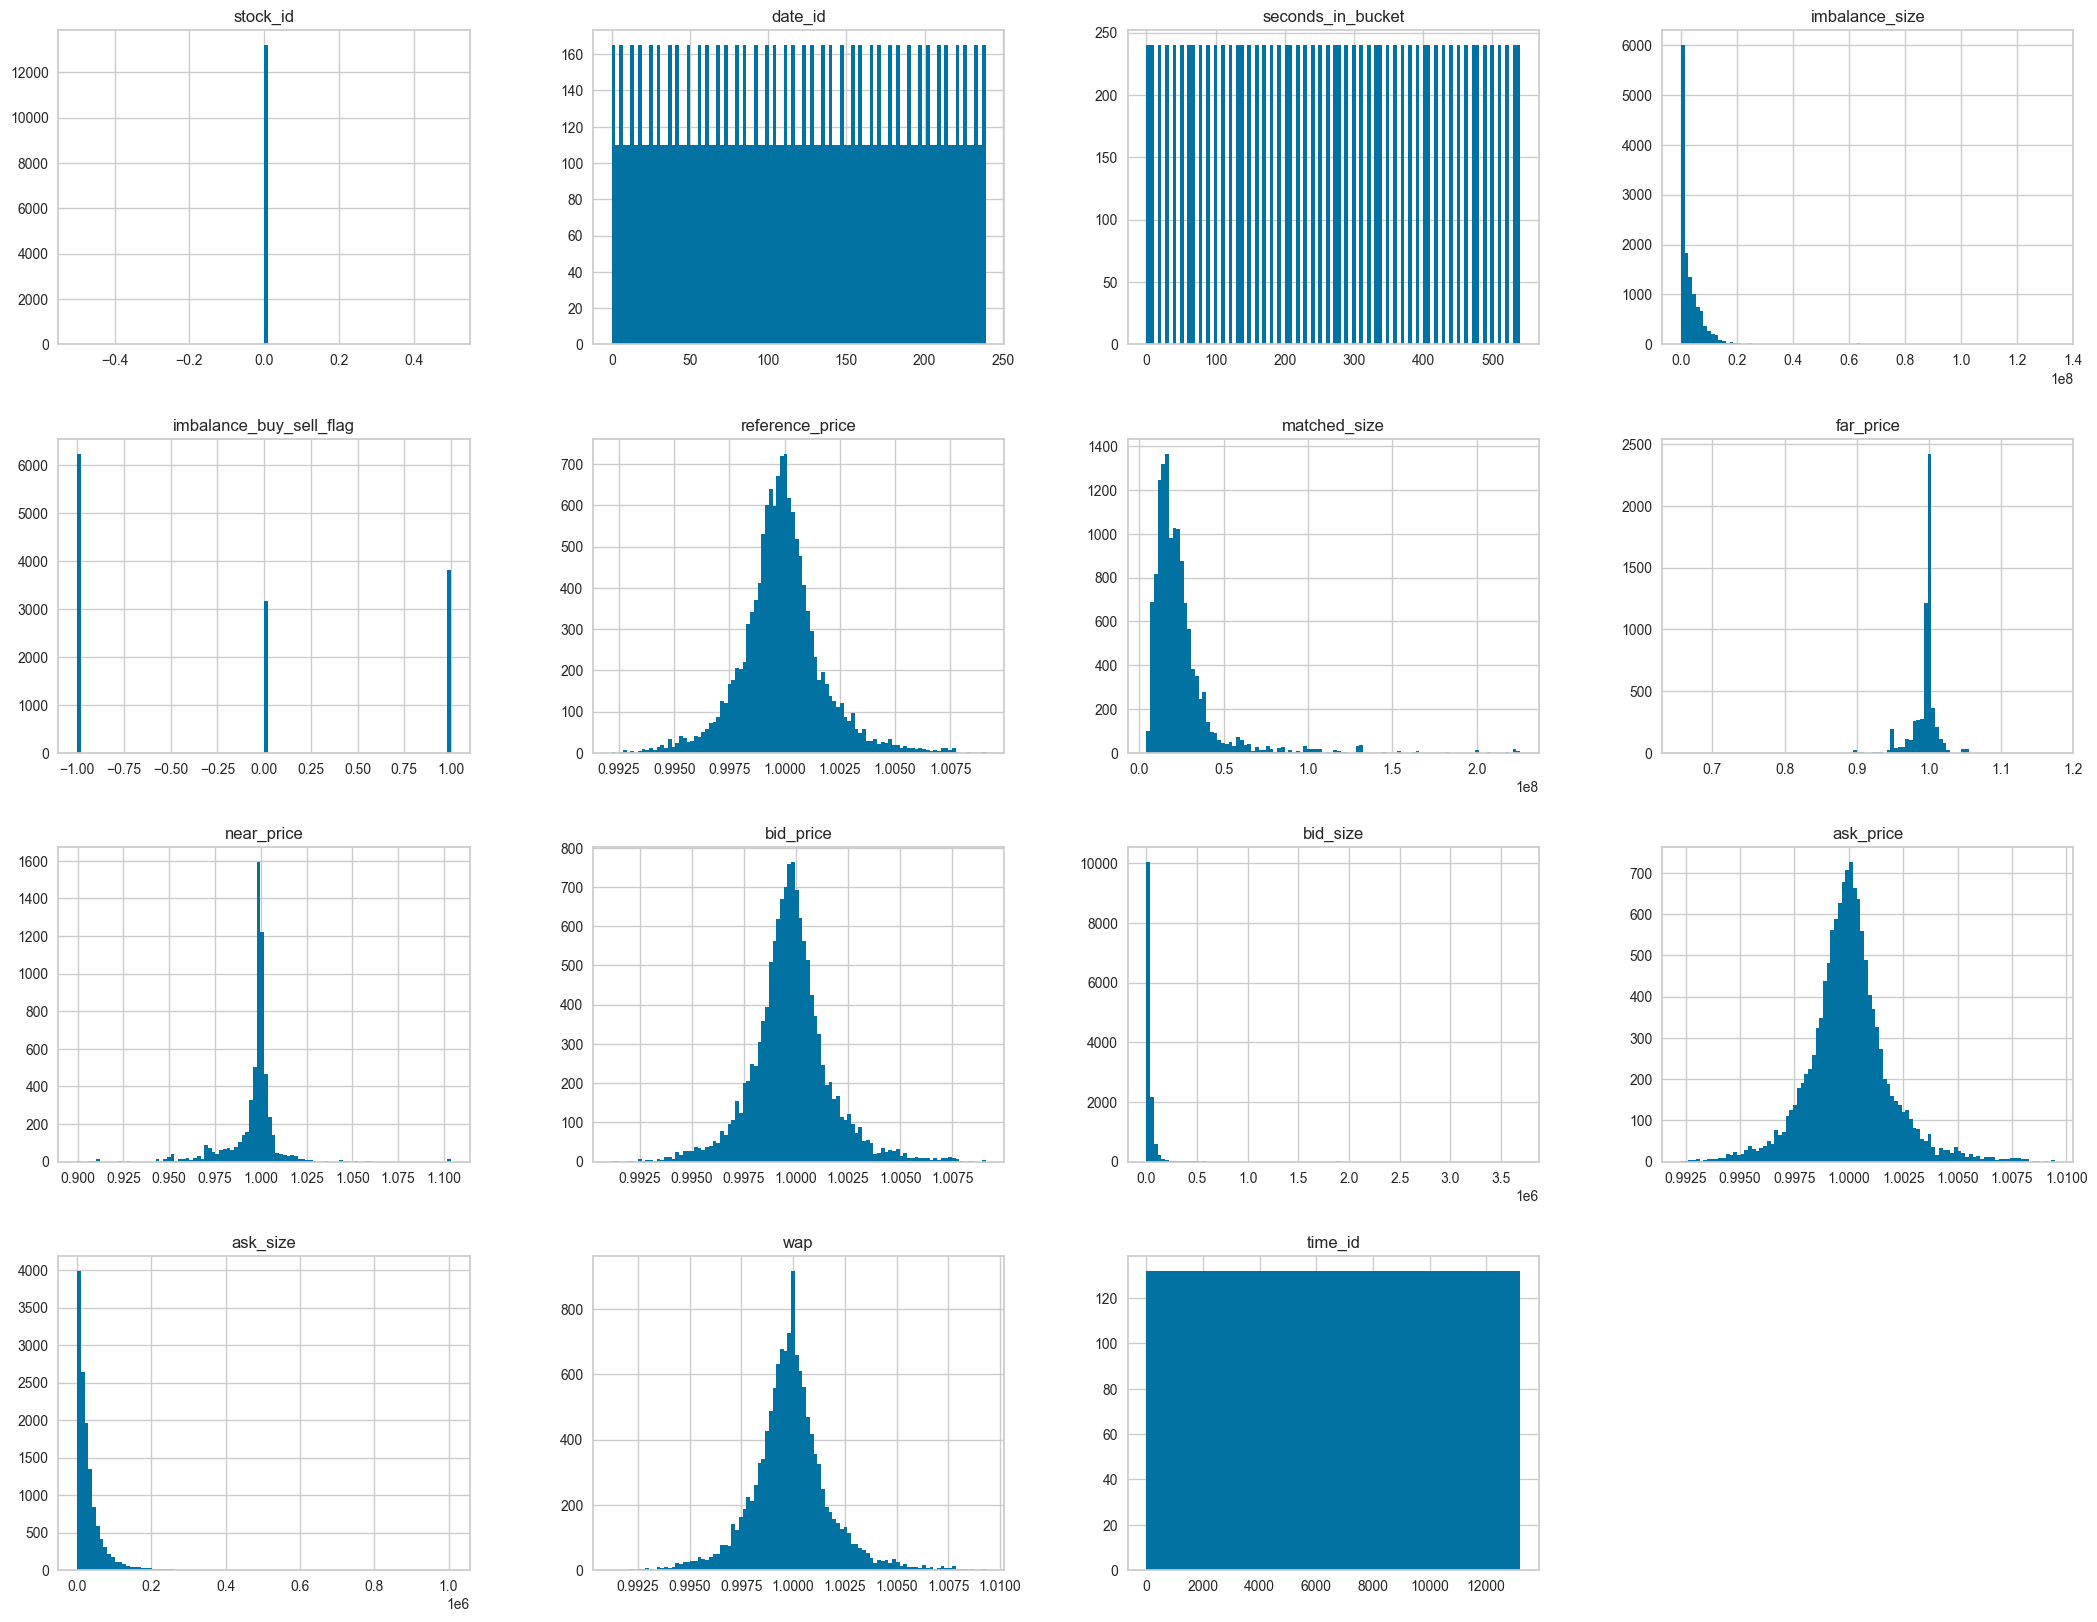

In [618]:
X_train.hist(bins=100, figsize=(26, 20))

In [619]:
for column in X_train.columns:
    data = X_train[column].dropna()

    stat, p_value = normaltest(X_train[column], nan_policy='omit')
    if p_value < 0.05:
        print(f"La variable {column} no sigue una distribución normal (p-value: {p_value})")
    else:
        print(f"La variable {column} parece seguir una distribución normal (p-value: {p_value})")


La variable stock_id parece seguir una distribución normal (p-value: nan)
La variable date_id no sigue una distribución normal (p-value: 0.0)
La variable seconds_in_bucket no sigue una distribución normal (p-value: 0.0)
La variable imbalance_size no sigue una distribución normal (p-value: 0.0)
La variable imbalance_buy_sell_flag no sigue una distribución normal (p-value: 0.0)
La variable reference_price no sigue una distribución normal (p-value: 6.127715726562203e-206)
La variable matched_size no sigue una distribución normal (p-value: 0.0)
La variable far_price no sigue una distribución normal (p-value: 0.0)
La variable near_price no sigue una distribución normal (p-value: 0.0)
La variable bid_price no sigue una distribución normal (p-value: 5.768931805155632e-209)
La variable bid_size no sigue una distribución normal (p-value: 0.0)
La variable ask_price no sigue una distribución normal (p-value: 7.062474248981392e-225)
La variable ask_size no sigue una distribución normal (p-value: 0

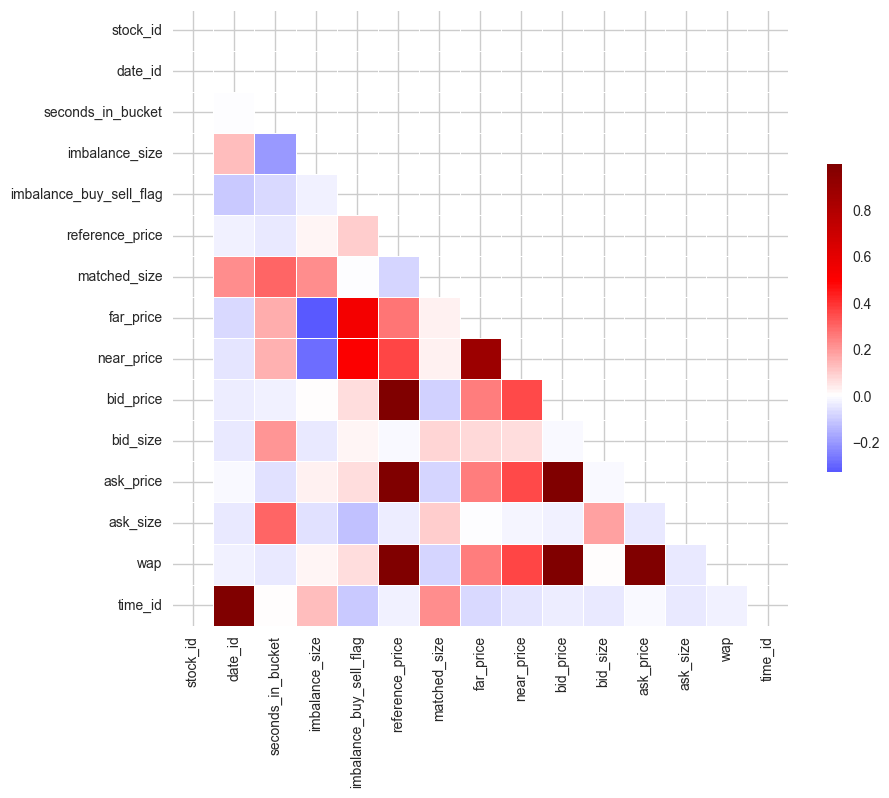

In [620]:
corr = X_train.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=mask, cmap='seismic',  center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});

# Preproceso

### Tratamiento de valores nulos

In [621]:
X_train.isna().sum()

stock_id                      0
date_id                       0
seconds_in_bucket             0
imbalance_size                0
imbalance_buy_sell_flag       0
reference_price               0
matched_size                  0
far_price                  7254
near_price                 7200
bid_price                     0
bid_size                      0
ask_price                     0
ask_size                      0
wap                           0
time_id                       0
dtype: int64

In [7]:
X_train['Nan_far_price'] = X_train['far_price'].isna().astype(int)
X_train['Nan_near_price'] = X_train['near_price'].isna().astype(int)

X_test['Nan_far_price'] = X_test['far_price'].isna().astype(int)
X_test['Nan_near_price'] = X_test['near_price'].isna().astype(int)


X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

In [623]:
X_train.isna().sum()

stock_id                   0
date_id                    0
seconds_in_bucket          0
imbalance_size             0
imbalance_buy_sell_flag    0
reference_price            0
matched_size               0
far_price                  0
near_price                 0
bid_price                  0
bid_size                   0
ask_price                  0
ask_size                   0
wap                        0
time_id                    0
Nan_far_price              0
Nan_near_price             0
dtype: int64

In [624]:
y_train.isna().sum()

0

### Generacion de nuevas variables Temporales

In [8]:
X_train["second"] = X_train["seconds_in_bucket"] % 60
X_train["minute"] = X_train["seconds_in_bucket"] // 60
X_train["day"] = X_train["date_id"] % 5
X_train["week"] = (X_train["date_id"] // 5) % 4
X_train["month"] = (X_train["date_id"] // 20) % 12

X_test["second"] = X_test["seconds_in_bucket"] % 60
X_test["minute"] = X_test["seconds_in_bucket"] // 60
X_test["day"] = X_test["date_id"] % 5
X_test["week"] = (X_test["date_id"] // 5) % 4
X_test["month"] = (X_test["date_id"] // 20) % 12

### Generación de nuevas variables de información

In [9]:
X_train["volume"] = X_train["ask_size"] + X_train["bid_size"]
X_train["avg_price"] = (X_train["ask_price"] + X_train["bid_price"]) / 2

X_test["volume"] = X_test["ask_size"] + X_test["bid_price"]
X_test["avg_price"] = (X_test["ask_price"] + X_test["bid_price"]) / 2

### One-Hot-Encoding

In [10]:
X_train_imbalance_buy_sell_flag = pd.get_dummies(X_train['imbalance_buy_sell_flag'], drop_first=True, prefix="imbalance_buy_sell_flag", prefix_sep="_").astype(int)
X_train_second = pd.get_dummies(X_train['second'], drop_first=True, prefix="second", prefix_sep="_").astype(int)
X_train_minute = pd.get_dummies(X_train['minute'], drop_first=True, prefix="minute", prefix_sep="_").astype(int)
X_train_day = pd.get_dummies(X_train['day'], drop_first=True, prefix="day", prefix_sep="_").astype(int)
X_train_week = pd.get_dummies(X_train['week'], drop_first=True, prefix="week", prefix_sep="_").astype(int)
X_train_month = pd.get_dummies(X_train['month'], drop_first=True, prefix="month", prefix_sep="_").astype(int)

X_test_imbalance_buy_sell_flag = pd.get_dummies(X_test['imbalance_buy_sell_flag'], drop_first=True, prefix="imbalance_buy_sell_flag", prefix_sep="_").astype(int)
X_test_second = pd.get_dummies(X_test['second'], drop_first=True, prefix="second", prefix_sep="_").astype(int)
X_test_minute = pd.get_dummies(X_test['minute'], drop_first=True, prefix="minute", prefix_sep="_").astype(int)
X_test_day = pd.get_dummies(X_test['day'], drop_first=True, prefix="day", prefix_sep="_").astype(int)
X_test_week = pd.get_dummies(X_test['week'], drop_first=True, prefix="week", prefix_sep="_").astype(int)
X_test_month = pd.get_dummies(X_test['month'], drop_first=True, prefix="month", prefix_sep="_").astype(int)

X_train = pd.concat([X_train, X_train_imbalance_buy_sell_flag, X_train_second, X_train_minute, X_train_day, X_train_week, X_train_month], axis=1)
X_train.drop(columns=['stock_id', 'imbalance_buy_sell_flag', 'second', 'minute', 'day', 'week', 'month'], inplace=True)

X_test = pd.concat([X_test, X_test_imbalance_buy_sell_flag, X_test_second, X_test_minute, X_test_day, X_test_week, X_test_month], axis=1)
X_test.drop(columns=['stock_id', 'imbalance_buy_sell_flag', 'second', 'minute', 'day', 'week', 'month'], inplace=True)

### Eliminación de variables

In [11]:
X_train = X_train.drop(columns=["date_id", "seconds_in_bucket", "time_id"], axis=1)
X_test = X_test.drop(columns=["date_id", "seconds_in_bucket", "time_id"], axis=1)

### Normalización

In [12]:
X_train_sin_estandarizar = X_train.copy()
X_test_sin_estandarizar = X_test.copy()

In [13]:
from sklearn.preprocessing import PowerTransformer

yj_power = PowerTransformer(method='yeo-johnson')

columnas_float64 = X_train.select_dtypes(include=['float64']).columns
X_train[columnas_float64] = yj_power.fit_transform(X_train[columnas_float64])
X_test[columnas_float64] = yj_power.transform(X_test[columnas_float64])

In [631]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
imbalance_size,13200.0,-1.722528e-16,1.000038e+00,-1.606183e+00,-5.919934e-01,3.247183e-01,7.234433e-01,2.565390e+00
reference_price,13200.0,1.361232e-18,4.133185e-16,-1.856154e-15,-2.046974e-16,3.469447e-18,2.046974e-16,1.883910e-15
matched_size,13200.0,-7.827167e-14,1.000038e+00,-3.610769e+00,-6.175401e-01,6.193915e-02,6.227896e-01,3.022223e+00
far_price,13200.0,3.768030e-17,1.000038e+00,-9.052775e-01,-9.052775e-01,-9.052775e-01,1.108666e+00,1.281610e+00
near_price,13200.0,-6.728624e-18,1.000038e+00,-9.128240e-01,-9.128240e-01,-9.128240e-01,1.098056e+00,1.207422e+00
bid_price,13200.0,-3.650804e-19,1.939131e-16,-9.853229e-16,-9.714451e-17,0.000000e+00,9.367507e-17,8.916479e-16
bid_size,13200.0,3.186677e-16,1.000038e+00,-2.561130e+00,-5.445236e-01,4.427560e-03,6.171048e-01,8.589488e+00
ask_price,13200.0,-1.823825e-18,5.537791e-16,-2.491063e-15,-2.844947e-16,0.000000e+00,2.671474e-16,2.581269e-15
ask_size,13200.0,-1.722528e-17,1.000038e+00,-2.658536e+00,-6.099332e-01,-1.399408e-02,5.955789e-01,5.059026e+00
wap,13200.0,3.522014e-19,2.110220e-16,-1.075529e-15,-1.040834e-16,3.469447e-18,1.040834e-16,9.783840e-16


# PCA

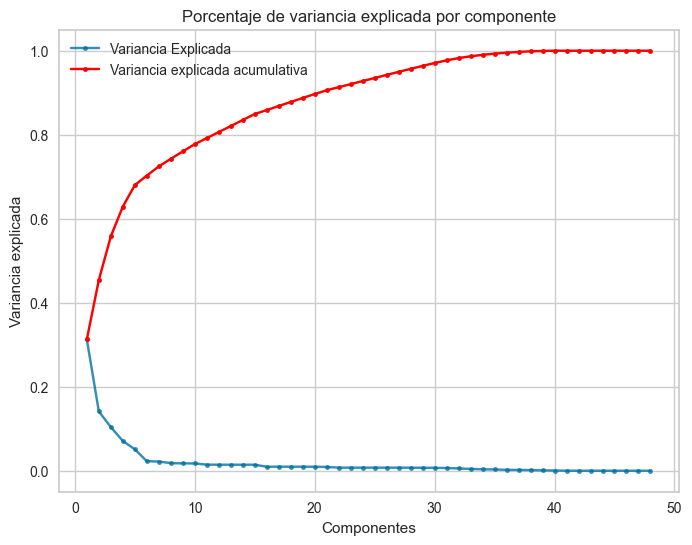

In [14]:
pca = PCA().fit(X_train);

fig = plt.figure(figsize=(8,6));
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),pca.explained_variance_ratio_ ,alpha=0.8,marker='.',label="Variancia Explicada");
y_label = plt.ylabel('Variancia explicada');
x_label = plt.xlabel('Componentes');
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),
         np.cumsum(pca.explained_variance_ratio_),
         c='red',marker='.',
         label="Variancia explicada acumulativa");
plt.legend();
plt.title('Porcentaje de variancia explicada por componente');

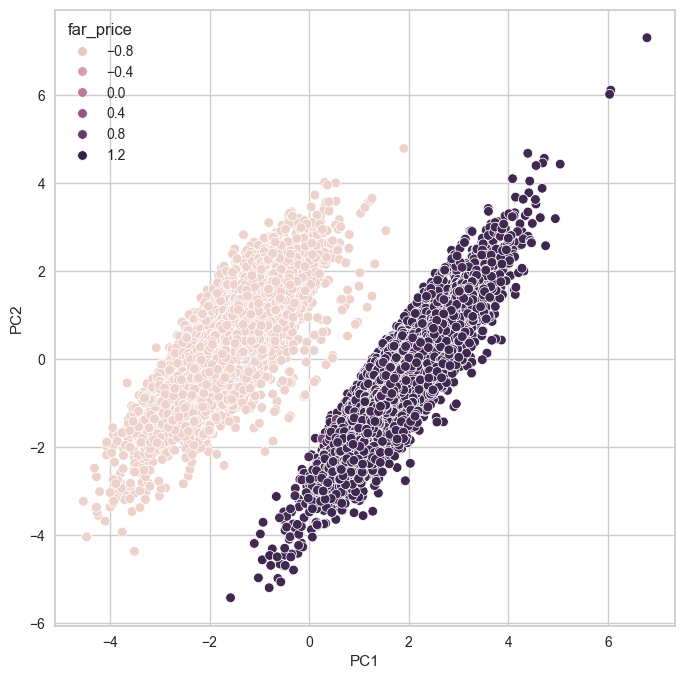

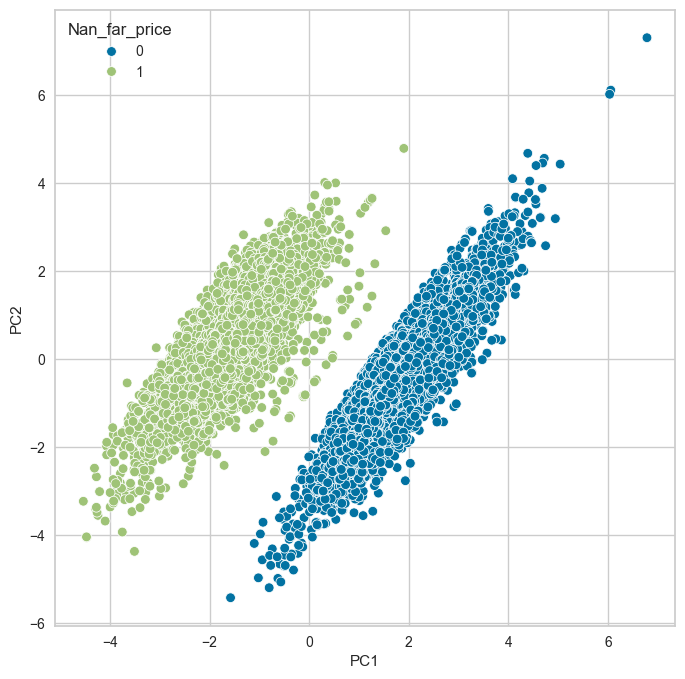

In [31]:
X_train_pca = pca.transform(X_train)[:, :2]
columns = ['PC1', 'PC2']
X_train_pca_df = pd.DataFrame(X_train_pca, columns=columns)
X_train_copy = pd.concat([X_train,X_train_pca_df],axis=1)
fig = plt.figure(figsize=(8, 8))
_= sns.scatterplot(x='PC1', y='PC2', hue="far_price",data=X_train_copy)
fig = plt.figure(figsize=(8, 8))
_= sns.scatterplot(x='PC1', y='PC2', hue="Nan_far_price",data=X_train_copy)


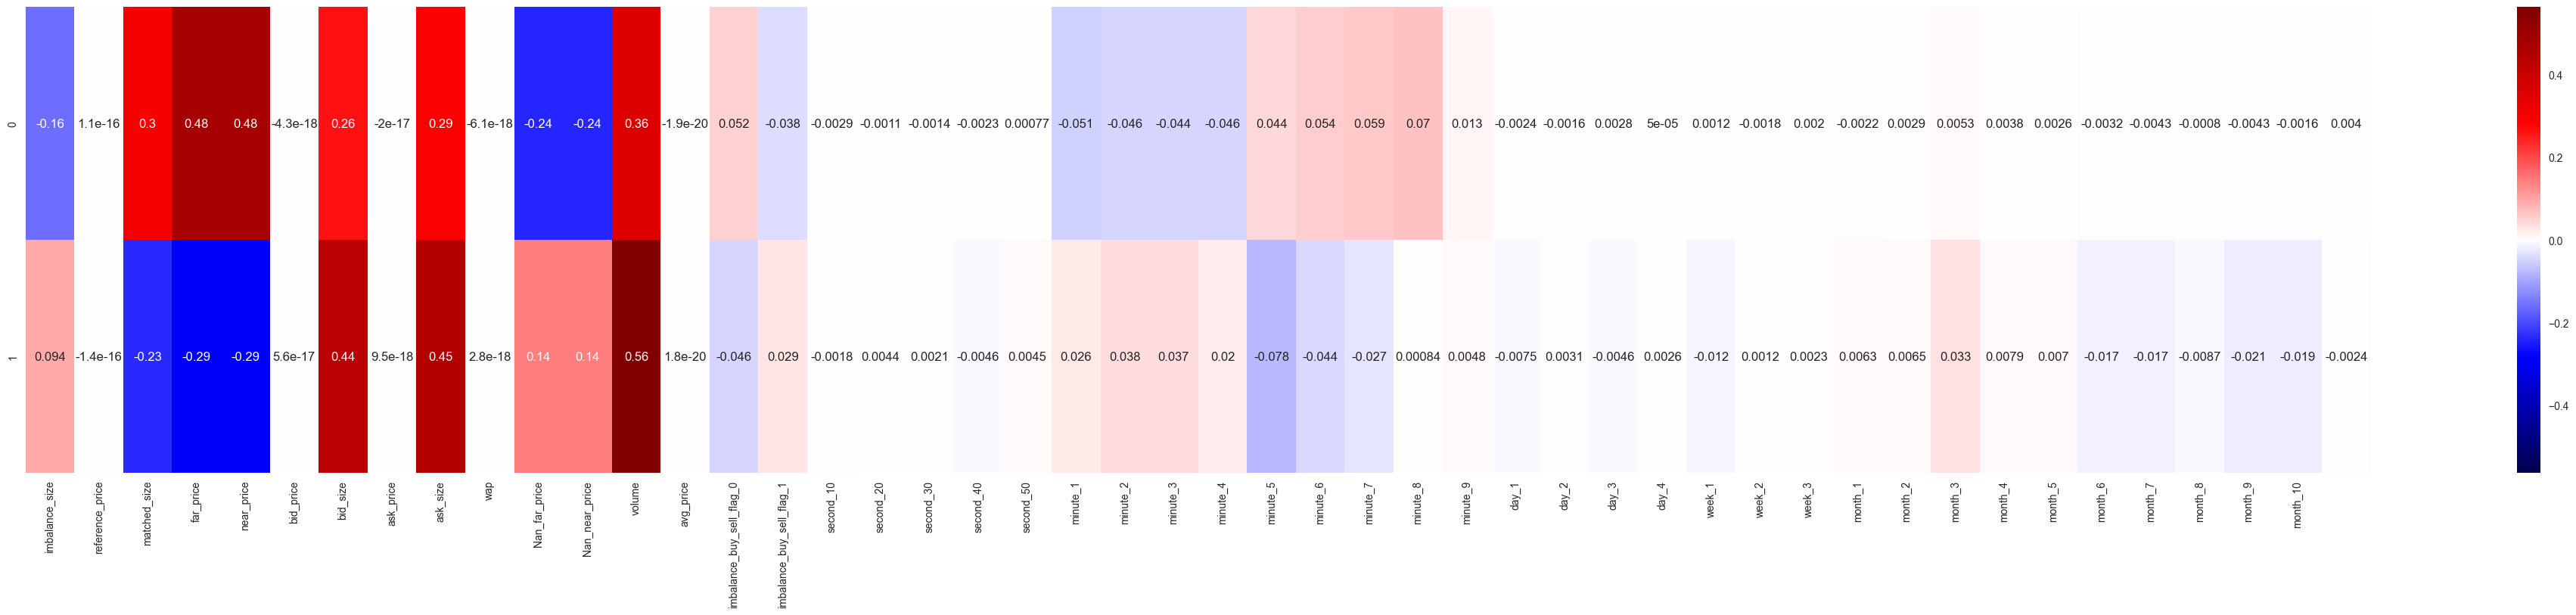

In [24]:
plt.figure(figsize=(50, 8))
sns.heatmap(pca.components_[0:2], cmap='seismic', 
            xticklabels=list(X_train.columns[:-1]),
            vmin=-np.max(np.abs(pca.components_[0:2])),
            vmax=np.max(np.abs(pca.components_[0:2])),
            annot=True);

# Time series split

In [634]:
tscv = TimeSeriesSplit(n_splits=11)
for i, (train_index, test_index) in enumerate(tscv.split(X_train)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")

Fold 0:
  Train: index=[   0    1    2 ... 1097 1098 1099]
  Test:  index=[1100 1101 1102 ... 2197 2198 2199]
Fold 1:
  Train: index=[   0    1    2 ... 2197 2198 2199]
  Test:  index=[2200 2201 2202 ... 3297 3298 3299]
Fold 2:
  Train: index=[   0    1    2 ... 3297 3298 3299]
  Test:  index=[3300 3301 3302 ... 4397 4398 4399]
Fold 3:
  Train: index=[   0    1    2 ... 4397 4398 4399]
  Test:  index=[4400 4401 4402 ... 5497 5498 5499]
Fold 4:
  Train: index=[   0    1    2 ... 5497 5498 5499]
  Test:  index=[5500 5501 5502 ... 6597 6598 6599]
Fold 5:
  Train: index=[   0    1    2 ... 6597 6598 6599]
  Test:  index=[6600 6601 6602 ... 7697 7698 7699]
Fold 6:
  Train: index=[   0    1    2 ... 7697 7698 7699]
  Test:  index=[7700 7701 7702 ... 8797 8798 8799]
Fold 7:
  Train: index=[   0    1    2 ... 8797 8798 8799]
  Test:  index=[8800 8801 8802 ... 9897 9898 9899]
Fold 8:
  Train: index=[   0    1    2 ... 9897 9898 9899]
  Test:  index=[ 9900  9901  9902 ... 10997 10998 10999]
Fold

# Regresión Lineal

In [635]:
lr = LinearRegression()

folds_nmse_lr = cross_val_score(lr, X_train, y_train, cv=tscv, scoring='neg_mean_squared_error')
lr_nmse_lr = np.mean(folds_nmse_lr)
lr_nmse_lr

-43.09777781788818

In [636]:
lr.fit(X_train, y_train)

LinearRegression()

In [637]:
y_pred = lr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 34.340270856458396


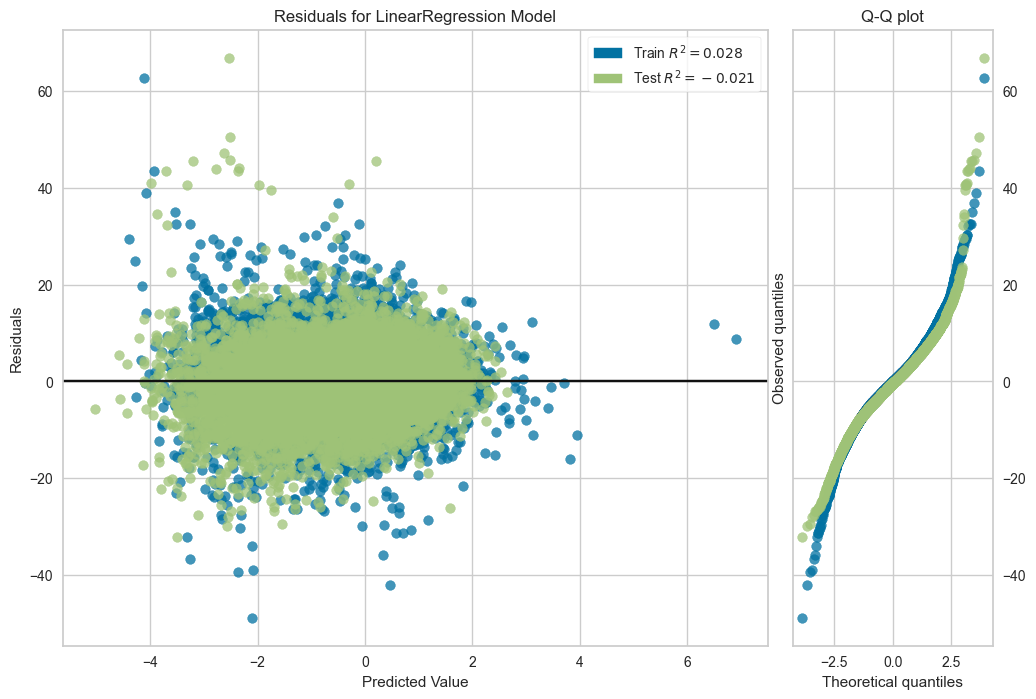

In [638]:
from yellowbrick.regressor import residuals_plot
plt.figure(figsize=(12,8));
viz = residuals_plot(lr, X_train, y_train, X_test, y_test, is_fitted=True, qqplot=True, hist=False);

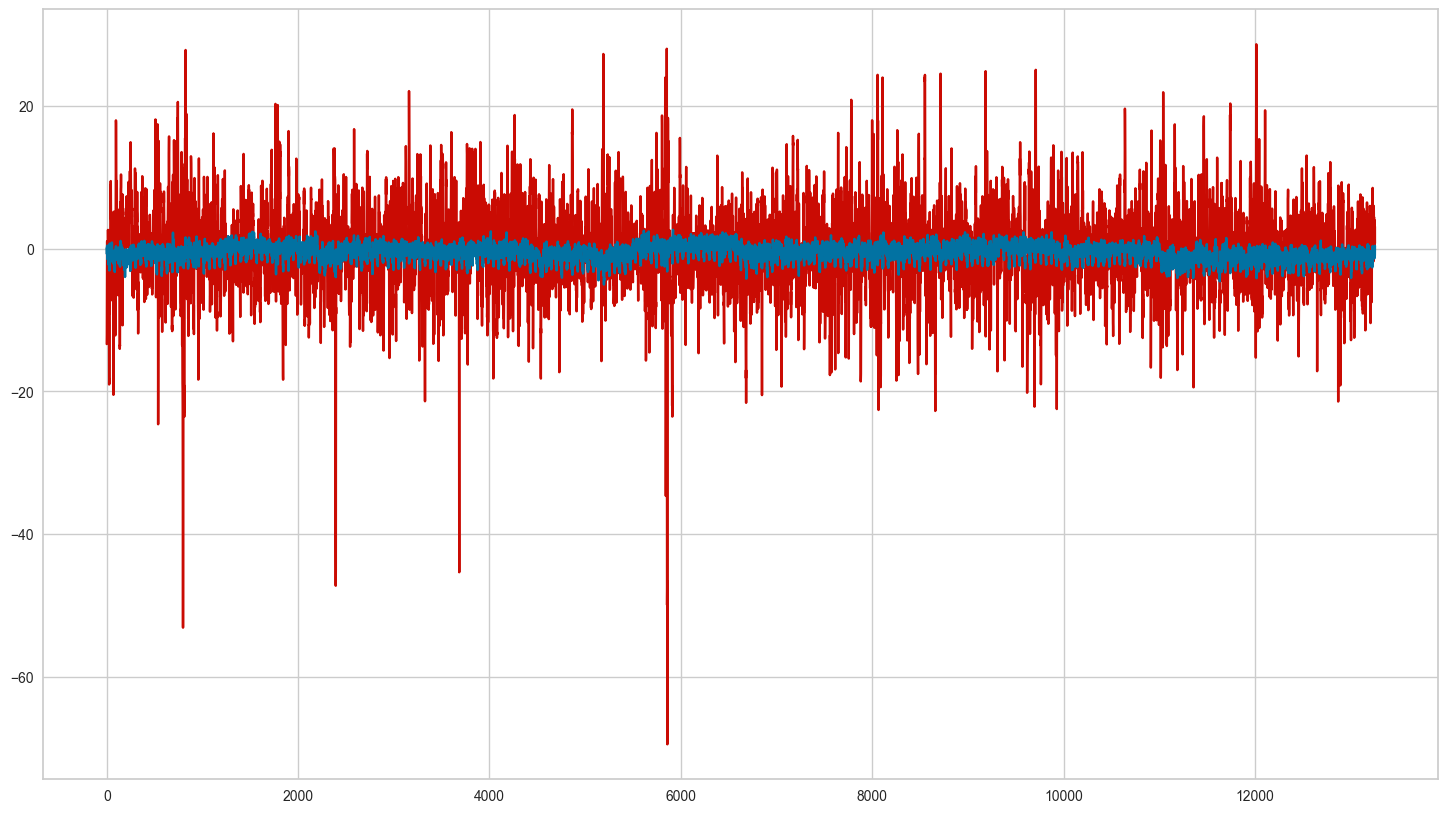

In [639]:
plt.figure(figsize=(18,10))
plt.plot(y_test,'r');
plt.plot(lr.predict(X_test),'b');

In [640]:
nombres_coefs = list(zip(list(X_train.columns), lr.coef_))
nombres_coefs_ordenados = sorted(nombres_coefs, key=lambda x: abs(x[1]), reverse=True)
for nombre, coef in nombres_coefs_ordenados:
    print(f'{nombre}: {coef}')

ask_price: -207317815651220.75
reference_price: -140366158594063.34
bid_price: -93989208513258.78
wap: -92814676603336.08
avg_price: 20541116167659.21
minute_8: -4882321673674.787
minute_7: -4882321673674.627
minute_6: -4882321673674.136
minute_9: -4882321673673.95
minute_5: -4882321673673.849
Nan_near_price: -4882321673624.711
Nan_far_price: -31.26242766638563
near_price: 25.277698115317502
far_price: -16.220793316363128
minute_4: -2.1154416572989128
minute_3: -0.9832211309137588
imbalance_buy_sell_flag_0: -0.9811428720497881
month_5: 0.8359375
month_8: 0.76513671875
imbalance_size: -0.5187542050914665
month_1: 0.514404296875
month_10: -0.48291015625
month_4: -0.47412109375
minute_2: -0.42058917402038826
bid_size: -0.409826580810793
month_11: -0.3876953125
week_3: 0.37255859375
week_1: 0.341796875
ask_size: 0.33464163470533576
month_9: 0.3115234375
month_7: 0.283203125
month_6: 0.277587890625
day_2: 0.2013759947340285
day_3: -0.19871644707026265
day_1: -0.1939600290176767
week_2: 0.18

# Lasso

In [641]:
lambdas = [1e-4,1e-3,1e-2,0.1, 0.5,1,5,10,50,100]

lasso = LassoCV(alphas=lambdas, cv=tscv)

folds_nmse_lasso = cross_val_score(lasso, X_train, y_train, cv=tscv, scoring='neg_mean_squared_error')
lr_nmse_lasso = np.mean(folds_nmse_lasso)
lr_nmse_lasso

c:\Users\marcg\miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.20364208670764583, tolerance: 0.15907316959520784
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\marcg\miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3580231482750378, tolerance: 0.15907316959520784
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\marcg\miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 310.12684347810836, tolerance: 0.15907316959520784
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\marcg\miniconda3\envs\te

-41.30662079925074

In [642]:
lasso.fit(X_train, y_train)

best_alpha = lasso.alpha_
print("Lambda seleccionada por LassoCV:", best_alpha)

y_pred_lasso = lasso.predict(X_test)

mse_lasso = mean_squared_error(y_test, y_pred_lasso)

print("Mean Squared Error (MSE):", mse_lasso)

Lambda seleccionada por LassoCV: 0.1
Mean Squared Error (MSE): 33.62722721583261


c:\Users\marcg\miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8756.865615314822, tolerance: 2.160329898803958
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\marcg\miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.73903476036503, tolerance: 4.787142515198837
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\marcg\miniconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17475.465496577963, tolerance: 4.787142515198837
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\marcg\miniconda3\envs\tensorflow\

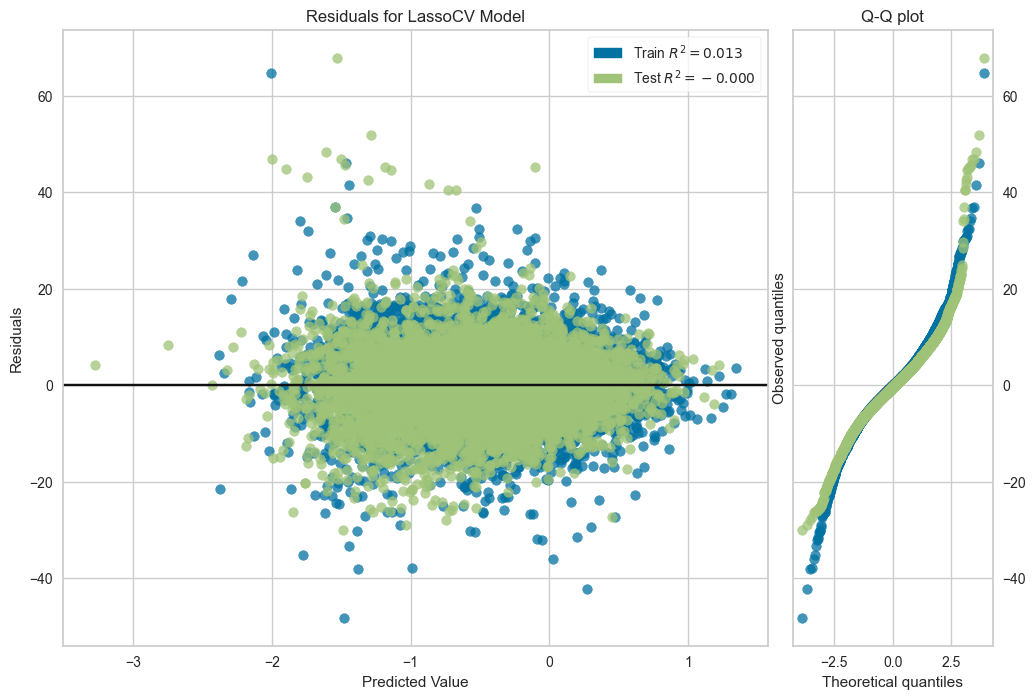

In [643]:
plt.figure(figsize=(12,8));
viz = residuals_plot(lasso, X_train, y_train, X_test, y_test, is_fitted=True, qqplot=True, hist=False);

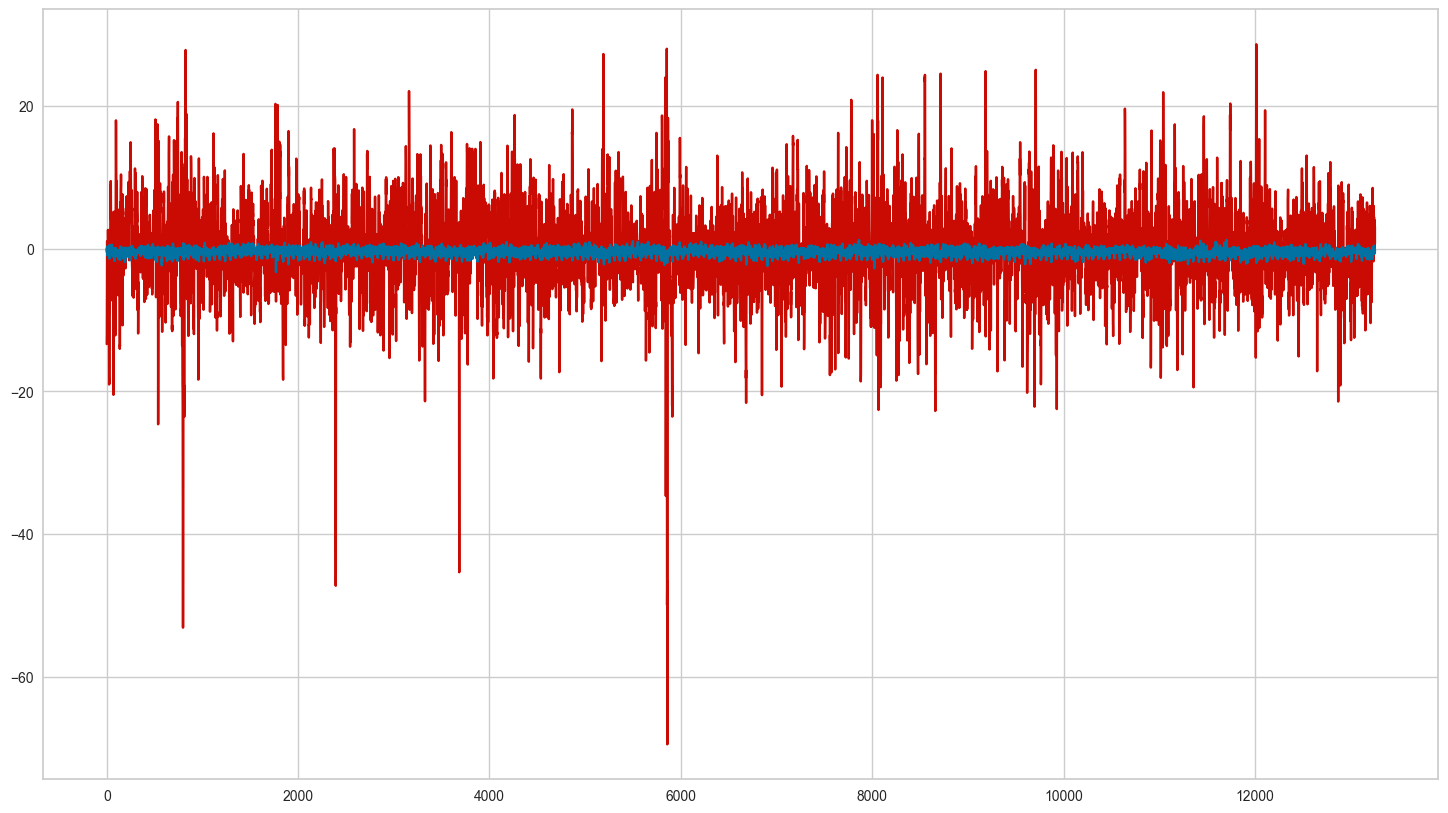

In [644]:
plt.figure(figsize=(18,10))
plt.plot(y_test,'r');
plt.plot(lasso.predict(X_test),'b');

In [645]:
nombres_coefs = list(zip(list(X_train.columns), lr.coef_))
nombres_coefs_ordenados = sorted(nombres_coefs, key=lambda x: abs(x[1]), reverse=True)
for nombre, coef in nombres_coefs_ordenados:
    print(f'{nombre}: {coef}')

ask_price: -207317815651220.75
reference_price: -140366158594063.34
bid_price: -93989208513258.78
wap: -92814676603336.08
avg_price: 20541116167659.21
minute_8: -4882321673674.787
minute_7: -4882321673674.627
minute_6: -4882321673674.136
minute_9: -4882321673673.95
minute_5: -4882321673673.849
Nan_near_price: -4882321673624.711
Nan_far_price: -31.26242766638563
near_price: 25.277698115317502
far_price: -16.220793316363128
minute_4: -2.1154416572989128
minute_3: -0.9832211309137588
imbalance_buy_sell_flag_0: -0.9811428720497881
month_5: 0.8359375
month_8: 0.76513671875
imbalance_size: -0.5187542050914665
month_1: 0.514404296875
month_10: -0.48291015625
month_4: -0.47412109375
minute_2: -0.42058917402038826
bid_size: -0.409826580810793
month_11: -0.3876953125
week_3: 0.37255859375
week_1: 0.341796875
ask_size: 0.33464163470533576
month_9: 0.3115234375
month_7: 0.283203125
month_6: 0.277587890625
day_2: 0.2013759947340285
day_3: -0.19871644707026265
day_1: -0.1939600290176767
week_2: 0.18

# SVM lineal

In [646]:
param = {'C':10**np.linspace(-3,3,101), 'epsilon':np.linspace(0,0.01,11)}

lsvr =  SVR(kernel='linear', max_iter=50000)
lsvr_bs = BayesSearchCV(lsvr,param,n_iter=15, 
                        cv=tscv, 
                        scoring=make_scorer(mean_squared_error, greater_is_better=False),
                        n_jobs=-1, 
                        refit=True, random_state=0)
lsvr_bs.fit(X_train, y_train);

In [647]:
show_html(pd.DataFrame(lsvr_bs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
12,"{'C': 0.007943282347242814, 'epsilon': 0.009000000000000001}",-41.160803,1
3,"{'C': 0.007943282347242814, 'epsilon': 0.008}",-41.160993,2
13,"{'C': 0.007943282347242814, 'epsilon': 0.007}",-41.161265,3
11,"{'C': 0.007943282347242814, 'epsilon': 0.004}",-41.162306,4
14,"{'C': 0.007943282347242814, 'epsilon': 0.001}",-41.163155,5


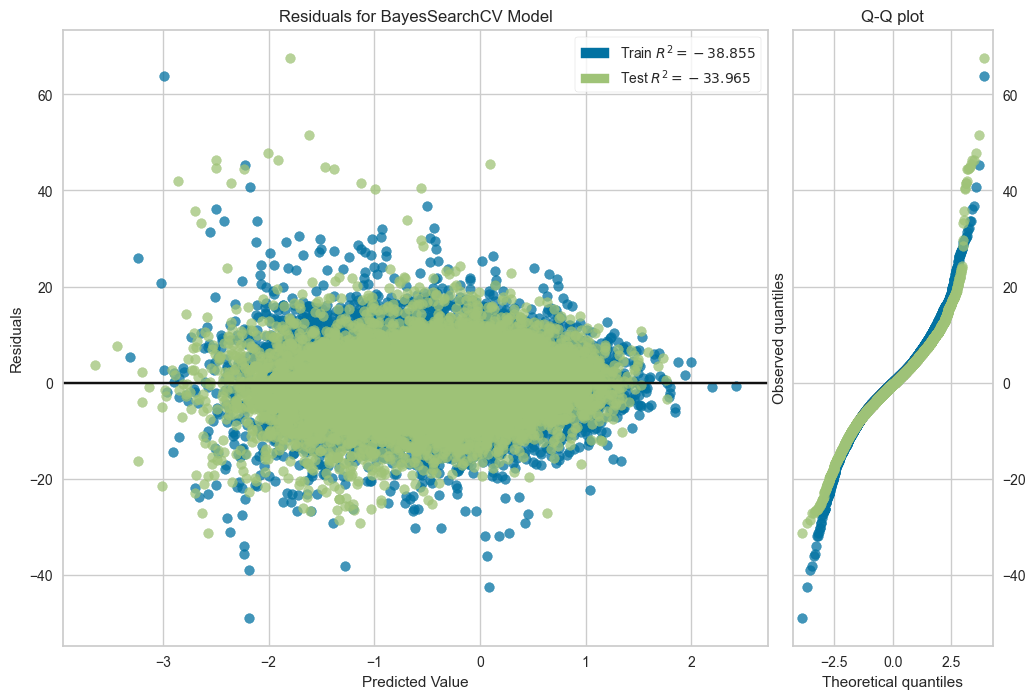

In [648]:
from yellowbrick.regressor import residuals_plot
plt.figure(figsize=(12,8));
viz = residuals_plot(lsvr_bs, X_train, y_train, X_test, y_test, is_fitted=True, qqplot=True, hist=False);

In [649]:
mean_squared_error(y_test,lsvr_bs.predict(X_test))

33.96485935555163

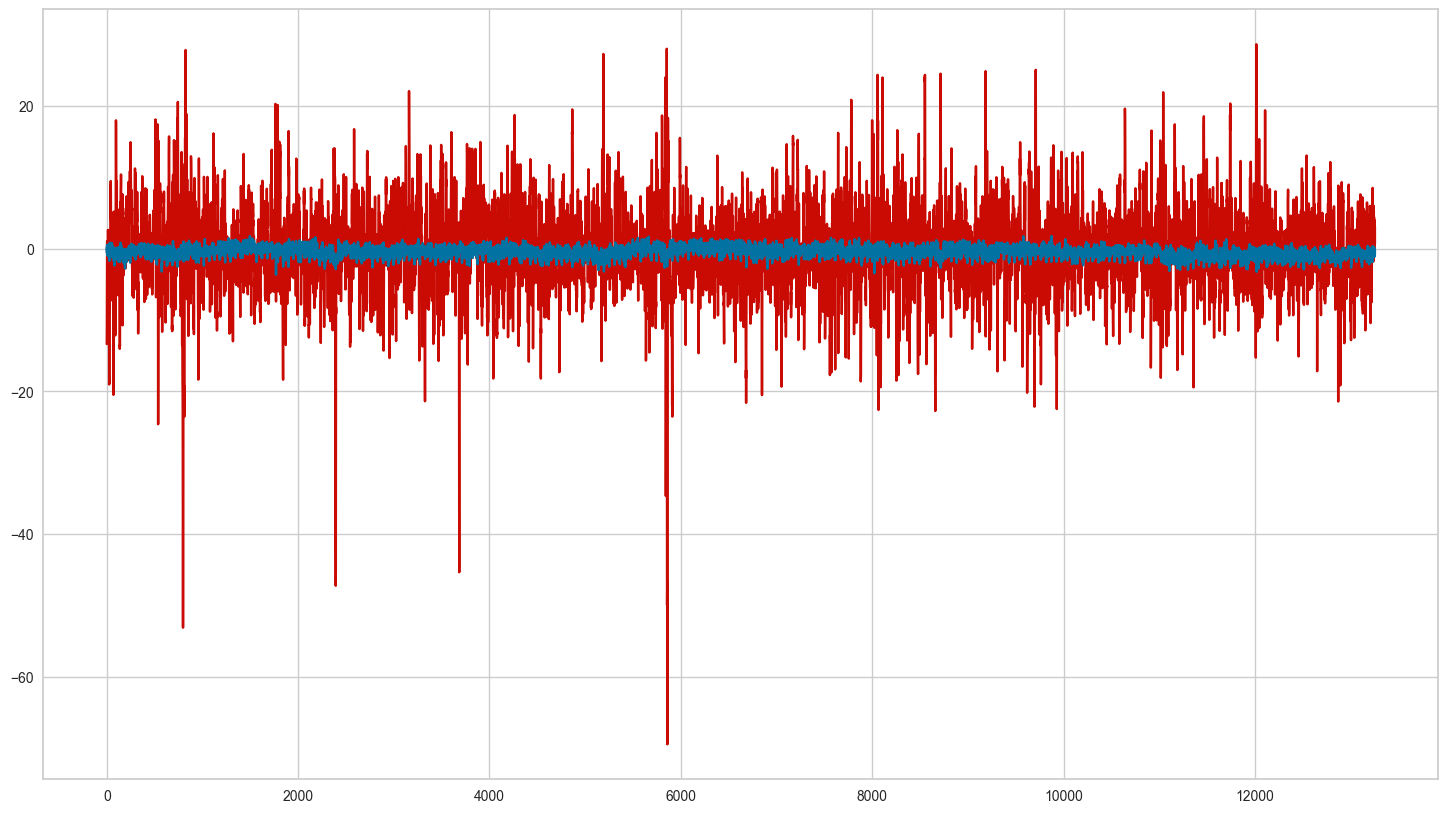

In [650]:
plt.figure(figsize=(18,10))
plt.plot(y_test,'r');
plt.plot(lsvr_bs.predict(X_test),'b');

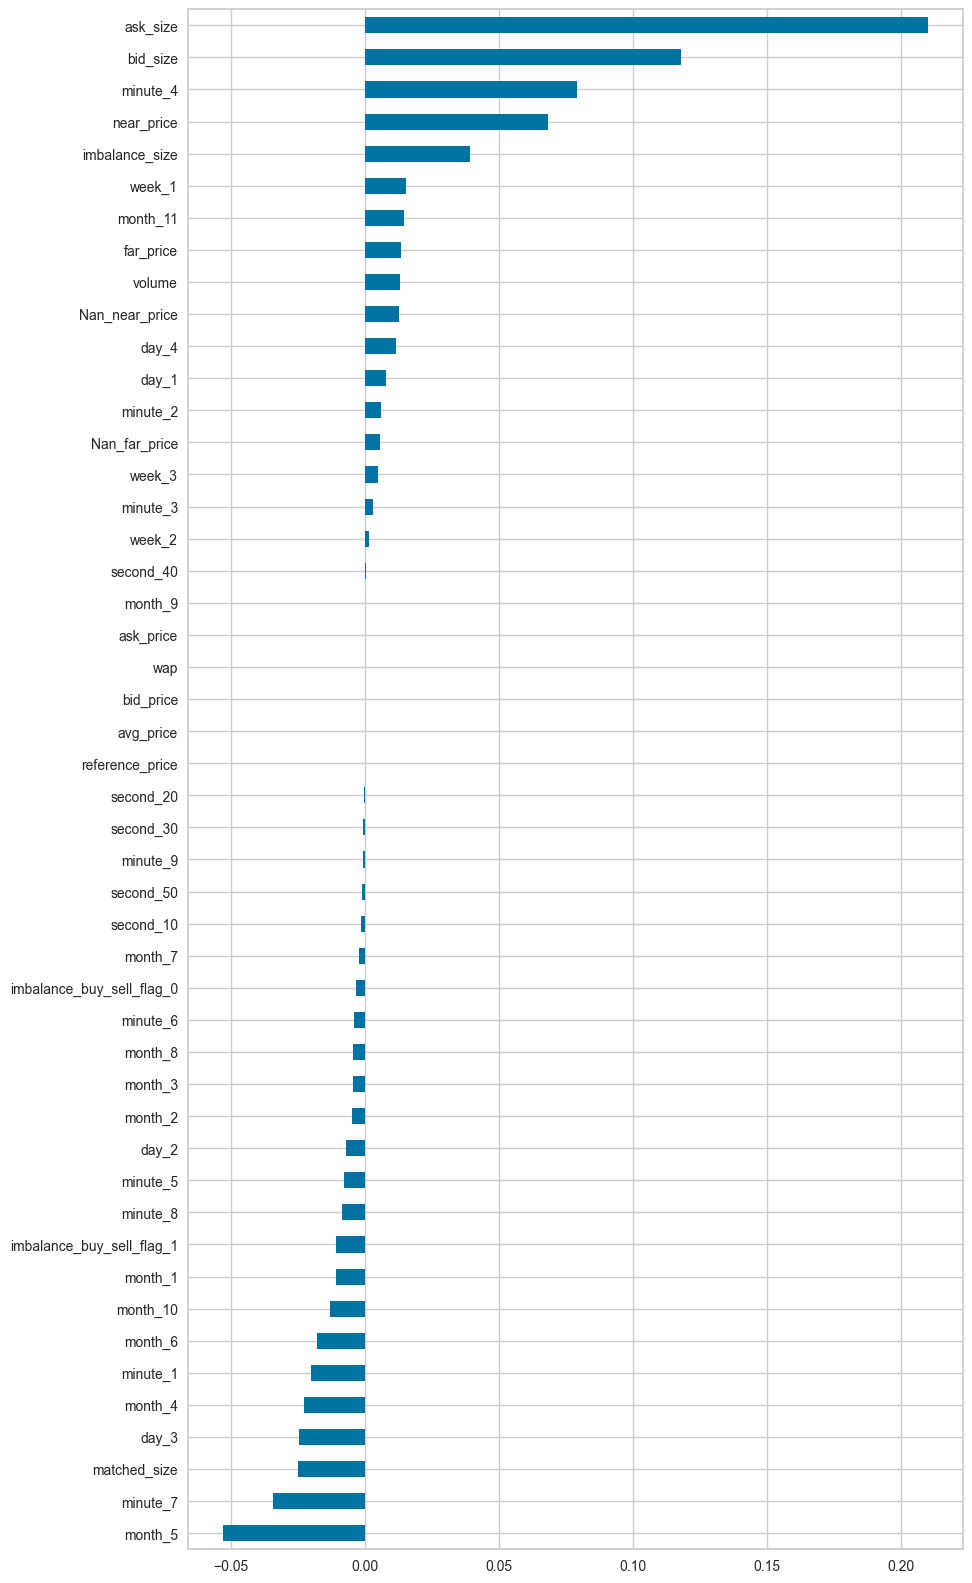

In [651]:
pi = permutation_importance(lsvr_bs,X_test, y_test, n_jobs=-1, random_state=0)
var_imp_dt = pd.DataFrame({'importance': pi.importances_mean}, index=X_test.columns)
var_imp_dt.sort_values(by='importance').plot.barh(figsize=(10,20), legend=False);

# SVM RBF

In [652]:
param = {'C':10**np.linspace(-3,3,101), 'gamma':['scale','auto'], 'epsilon':np.linspace(0,0.01,11)}

rbsvr =  SVR(kernel='rbf', max_iter=50000, cache_size=2000)
rbsvr_bs = BayesSearchCV(rbsvr,param,n_iter=15, 
                        cv=tscv,
                        scoring=make_scorer(mean_squared_error, greater_is_better=False),
                        n_jobs=-1, 
                        refit=True, random_state=0)
rbsvr_bs.fit(X_train, y_train);

In [653]:
show_html(pd.DataFrame(rbsvr_bs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
9,"{'C': 0.16595869074375597, 'epsilon': 0.004, 'gamma': 'auto'}",-41.181472,1
11,"{'C': 0.16595869074375597, 'epsilon': 0.007, 'gamma': 'auto'}",-41.181527,2
10,"{'C': 0.16595869074375597, 'epsilon': 0.008, 'gamma': 'scale'}",-41.272180,3
1,"{'C': 0.03630780547701014, 'epsilon': 0.01, 'gamma': 'scale'}",-41.288542,4
12,"{'C': 0.03630780547701014, 'epsilon': 0.001, 'gamma': 'auto'}",-41.320992,5


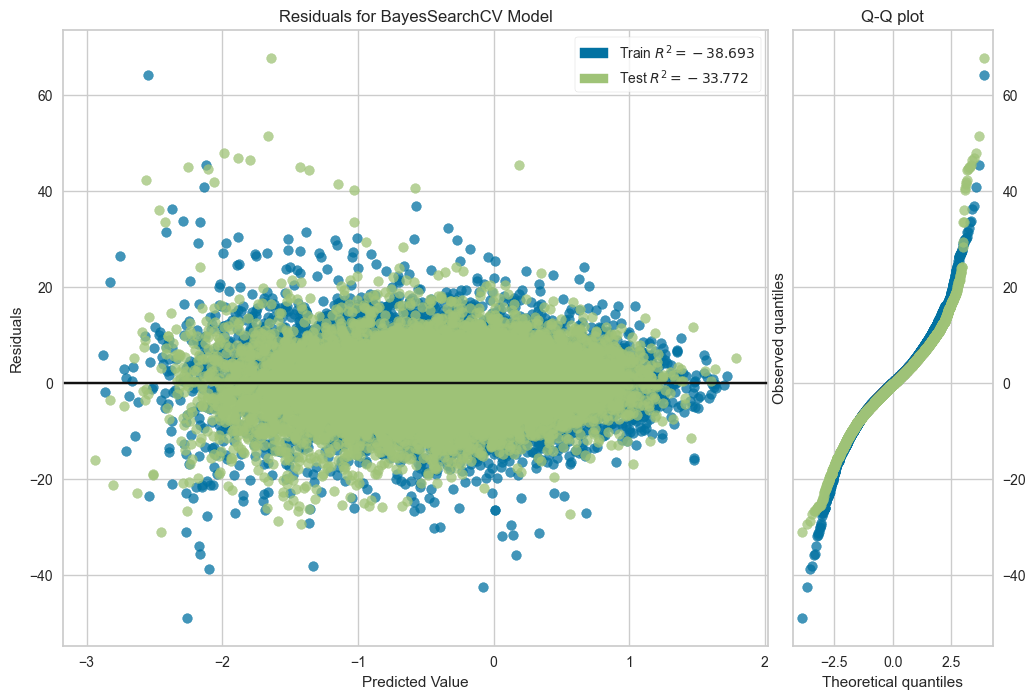

In [654]:
plt.figure(figsize=(12,8));
viz = residuals_plot(rbsvr_bs, X_train, y_train, X_test, y_test, is_fitted=True, qqplot=True, hist=False);

In [655]:
mean_squared_error(y_test,rbsvr_bs.predict(X_test))

33.772276066554376

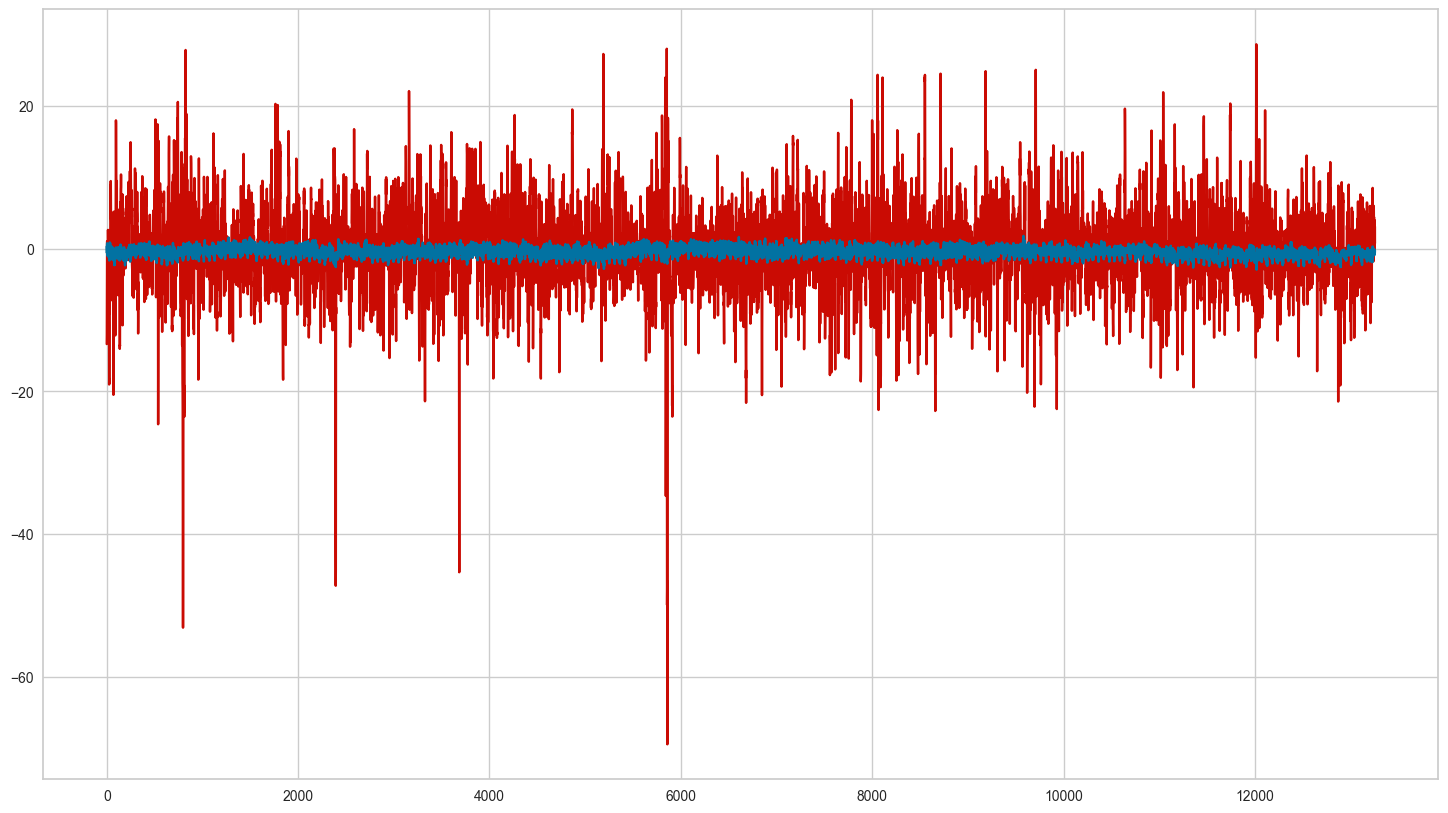

In [656]:
plt.figure(figsize=(18,10))
plt.plot(y_test,'r');
plt.plot(rbsvr_bs.predict(X_test),'b');

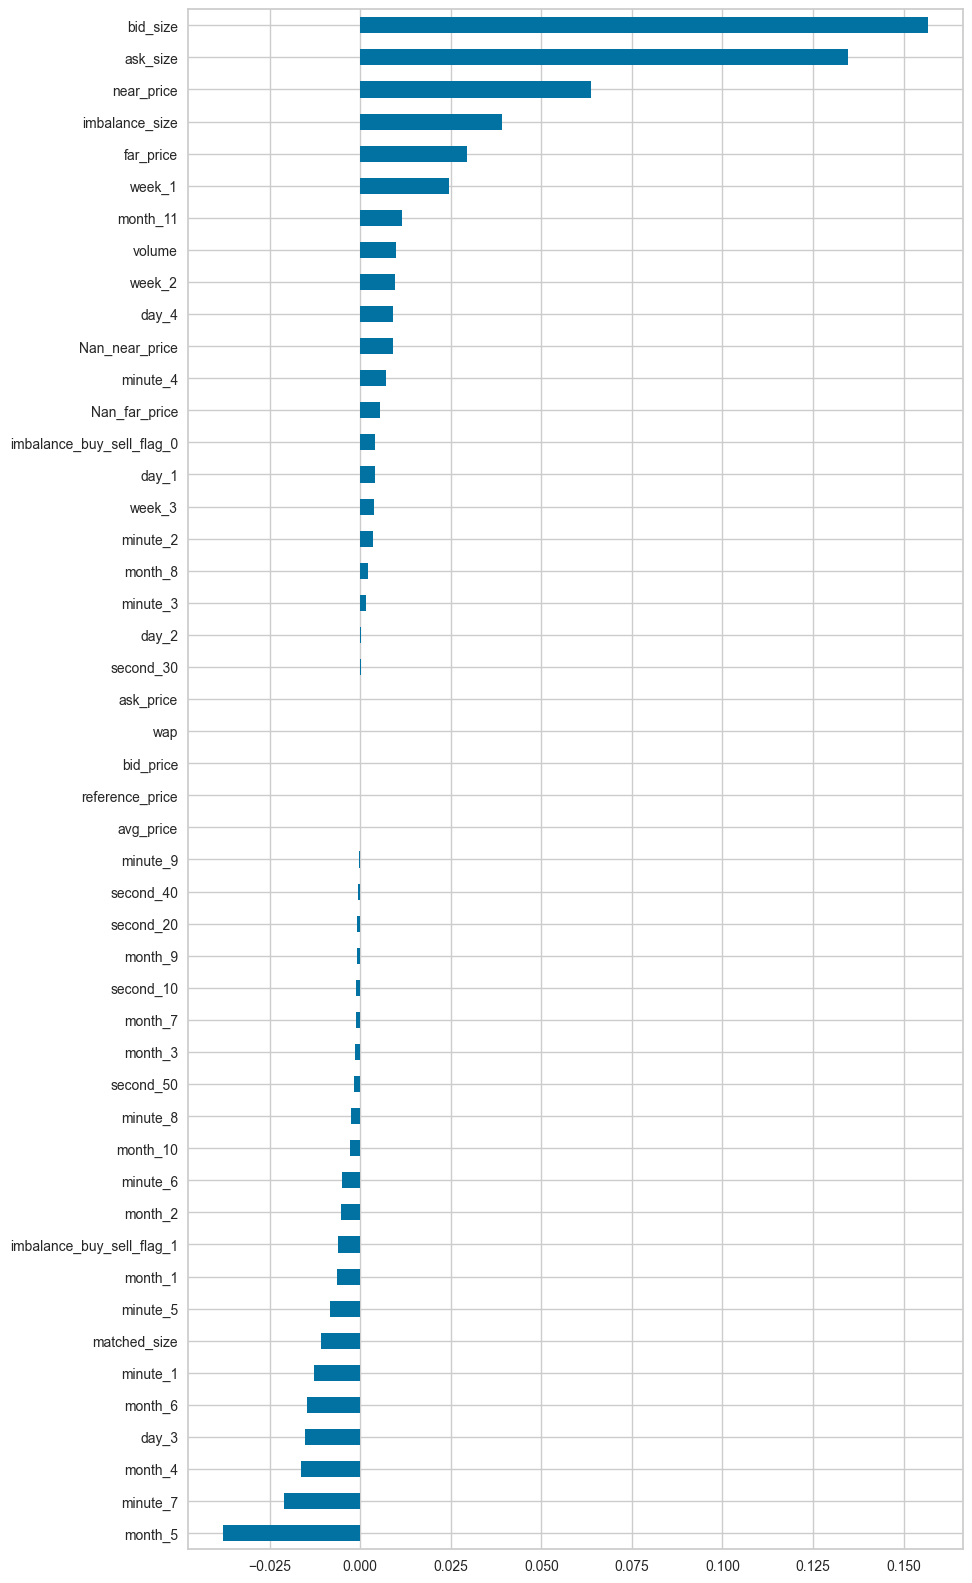

In [657]:
pi = permutation_importance(rbsvr_bs,X_test, y_test, n_jobs=-1, random_state=0)
var_imp_dt = pd.DataFrame({'importance': pi.importances_mean}, index=X_test.columns)
var_imp_dt.sort_values(by='importance').plot.barh(figsize=(10,20), legend=False);

# Random Forest

In [658]:
param = {'n_estimators': [5,10,25,40, 50, 75,100, 200], 
         'criterion':['absolute_error', 'squared_error'], 
         'max_depth':[None, 1, 2, 3,  5,  8, 9,10,15],
         'min_samples_leaf':[1,2,3,5,10]}

rf =  RandomForestRegressor(random_state=0)
rf_bs =  BayesSearchCV(rf,param,n_iter=5, cv=tscv, scoring=make_scorer(mean_squared_error, greater_is_better=False), n_jobs=-1, refit=True, random_state=0)
rf_bs.fit(X_train_sin_estandarizar, y_train);

In [659]:
show_html(pd.DataFrame(rf_bs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
4,"{'criterion': 'absolute_error', 'max_depth': 2, 'min_samples_leaf': 5, 'n_estimators': 25}",-41.739507,1
1,"{'criterion': 'absolute_error', 'max_depth': 15, 'min_samples_leaf': 10, 'n_estimators': 50}",-42.520503,2
3,"{'criterion': 'absolute_error', 'max_depth': 9, 'min_samples_leaf': 3, 'n_estimators': 40}",-43.771736,3
0,"{'criterion': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 3, 'n_estimators': 75}",-46.760285,4
2,"{'criterion': 'squared_error', 'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 10}",-51.924832,5


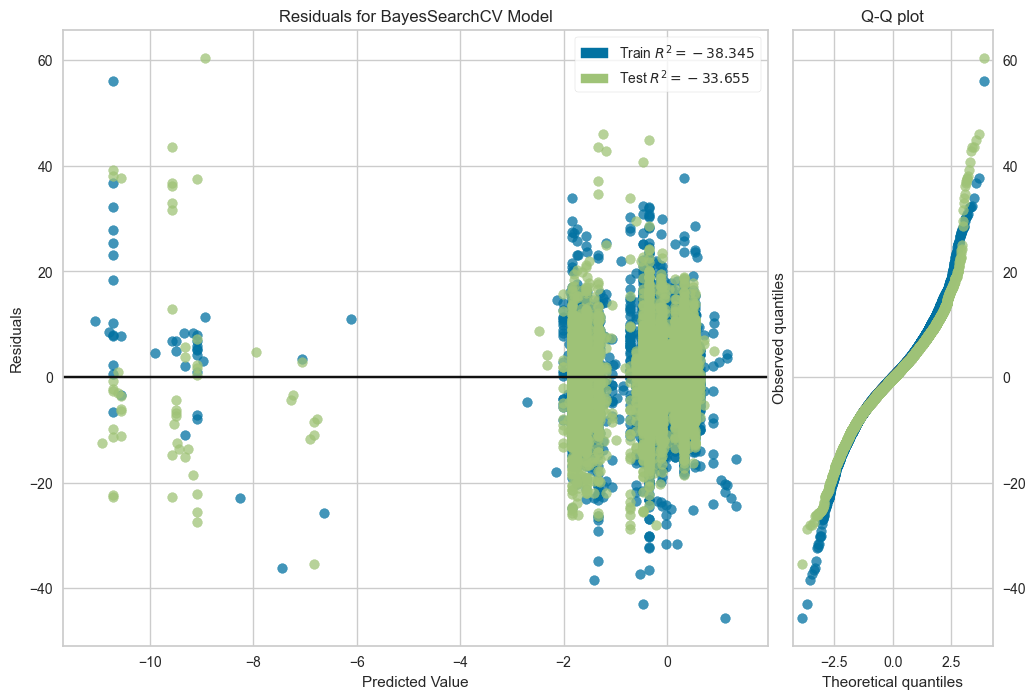

In [660]:
plt.figure(figsize=(12,8));
viz = residuals_plot(rf_bs, X_train_sin_estandarizar, y_train, X_test_sin_estandarizar, y_test, is_fitted=True, qqplot=True, hist=False);

In [661]:
mean_squared_error(y_test,rf_bs.predict(X_test_sin_estandarizar))

33.65521228942065

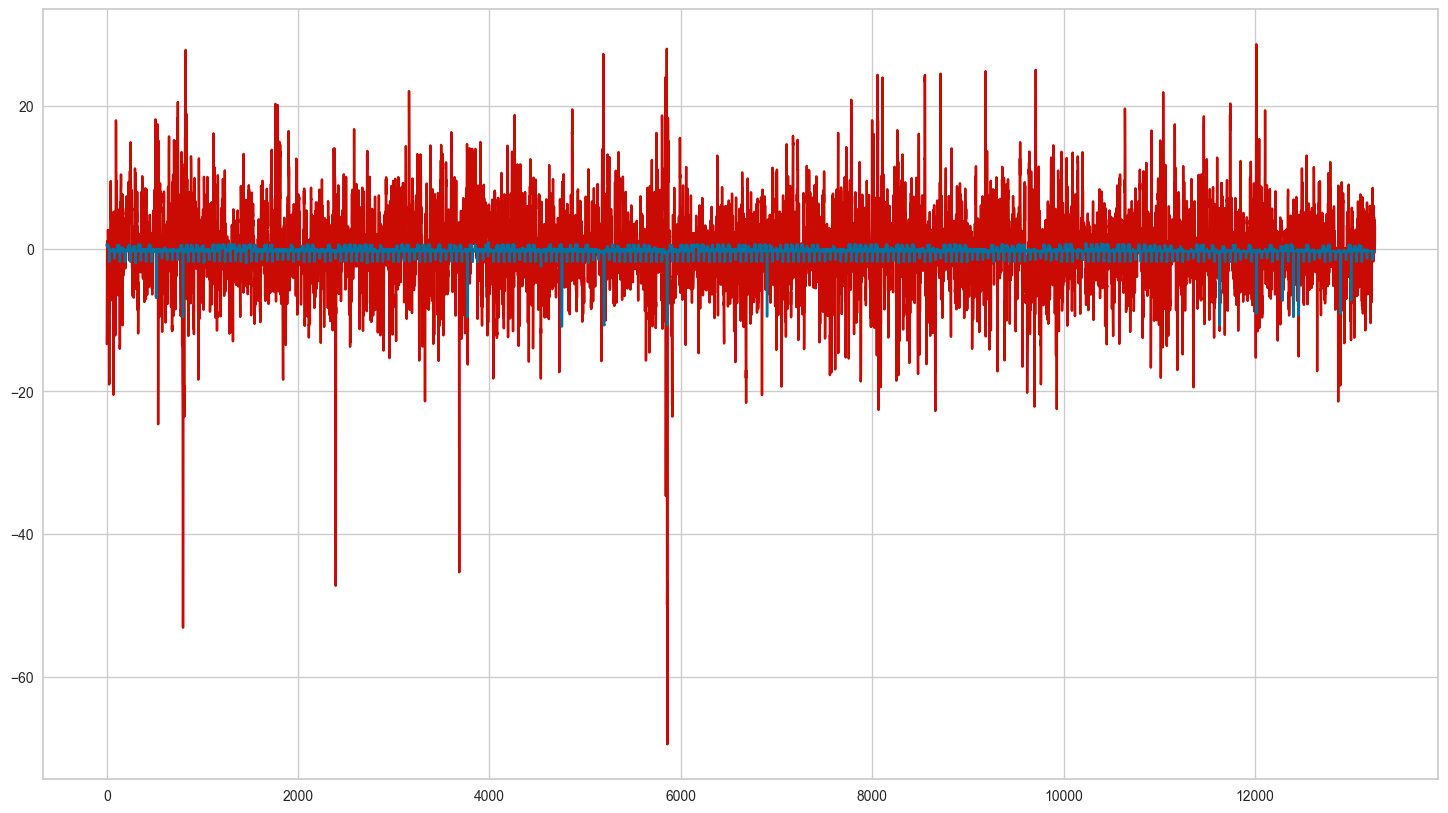

In [662]:
plt.figure(figsize=(18,10))
plt.plot(y_test,'r');
plt.plot(rf_bs.predict(X_test_sin_estandarizar),'b');

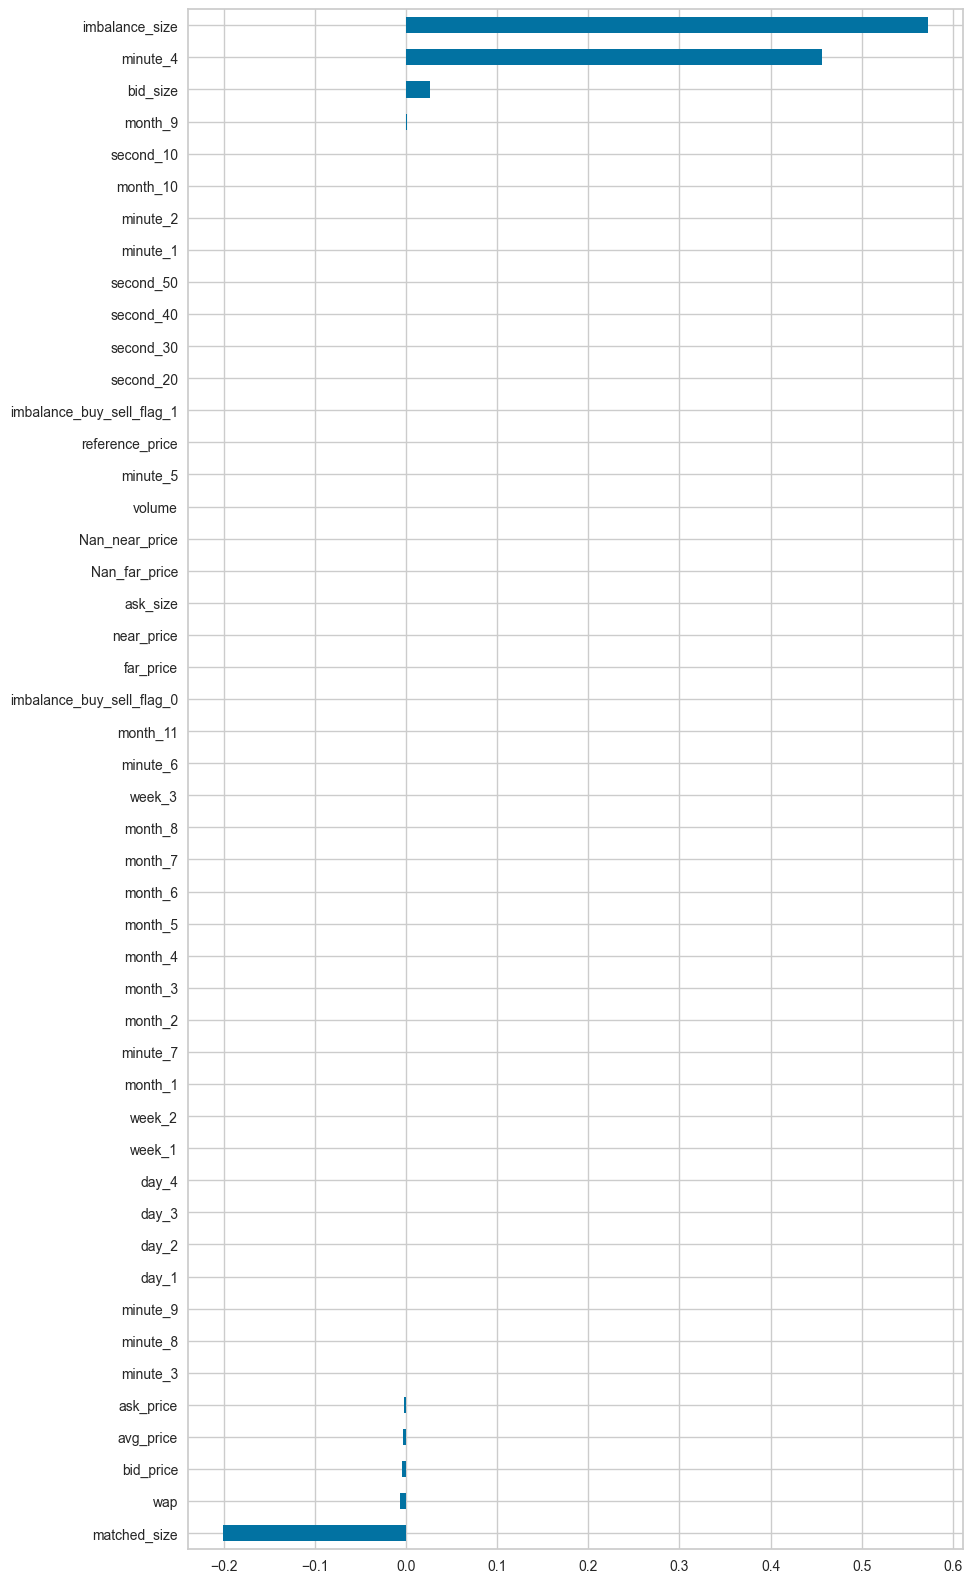

In [663]:
pi = permutation_importance(rf_bs,X_test_sin_estandarizar, y_test, n_jobs=-1, random_state=0)
var_imp_dt = pd.DataFrame({'importance': pi.importances_mean}, index=X_test.columns)
var_imp_dt.sort_values(by='importance').plot.barh(figsize=(10,20), legend=False);

# GradientBoosting

In [664]:
param = {'n_estimators': [5,10,25,40, 50, 75,100, 200], 
         'loss':['squared_error', 'absolute_error'], 
         'criterion':['squared_error'], 
         'max_depth':[None, 1, 2, 3,  5,  8, 9,10,15],
         'min_samples_leaf':[1,2,3,5,10], 
         'learning_rate':[0.1,0.5, 1,3, 5, 10, 15]}

gb =  GradientBoostingRegressor(random_state=0,n_iter_no_change=5)
gb_bs =  BayesSearchCV(gb,param,n_iter=15, cv=tscv, scoring=make_scorer(mean_squared_error, greater_is_better=False), n_jobs=-1, refit=True, random_state=0)
gb_bs.fit(X_train_sin_estandarizar, y_train);

c:\Users\marcg\miniconda3\envs\tensorflow\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\marcg\miniconda3\envs\tensorflow\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


In [665]:
show_html(pd.DataFrame(gb_bs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
2,"{'criterion': 'squared_error', 'learning_rate': 0.1, 'loss': 'absolute_error', 'max_depth': 2, 'min_samples_leaf': 2, 'n_estimators': 25}",-41.473720,1
4,"{'criterion': 'squared_error', 'learning_rate': 0.5, 'loss': 'squared_error', 'max_depth': 2, 'min_samples_leaf': 2, 'n_estimators': 25}",-49.325606,2
10,"{'criterion': 'squared_error', 'learning_rate': 1.0, 'loss': 'absolute_error', 'max_depth': 9, 'min_samples_leaf': 3, 'n_estimators': 200}",-54.204921,3
9,"{'criterion': 'squared_error', 'learning_rate': 3.0, 'loss': 'absolute_error', 'max_depth': 9, 'min_samples_leaf': 1, 'n_estimators': 75}",-13527.104125,4
12,"{'criterion': 'squared_error', 'learning_rate': 3.0, 'loss': 'absolute_error', 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 75}",-85202.159113,5


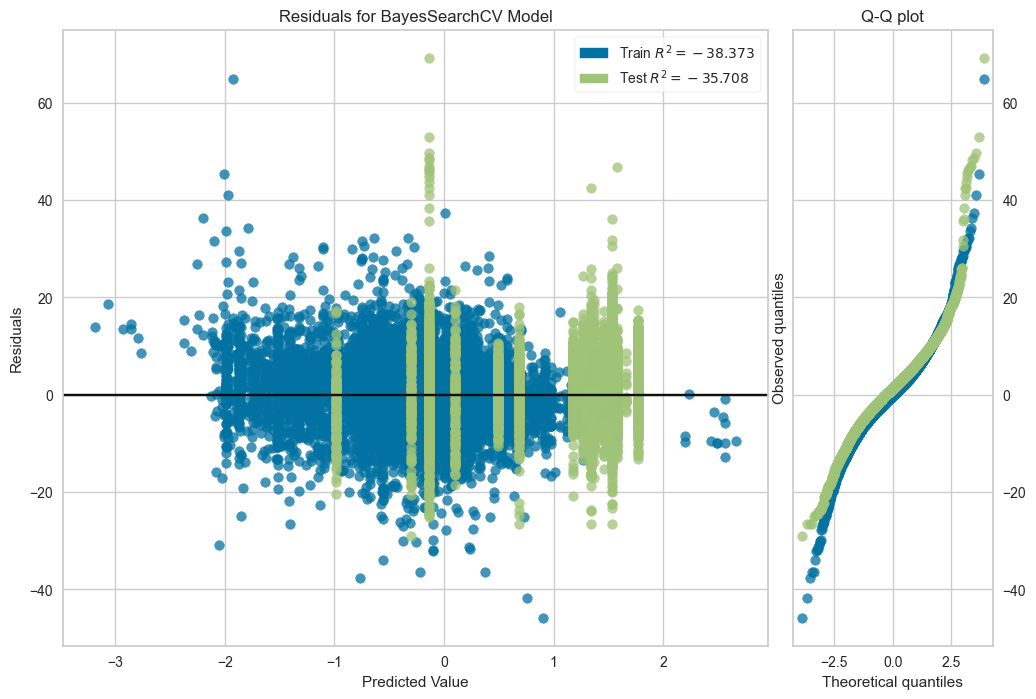

In [666]:
from yellowbrick.regressor import residuals_plot
plt.figure(figsize=(12,8));
viz = residuals_plot(gb_bs, X_train_sin_estandarizar, y_train, X_test, y_test, is_fitted=True, qqplot=True, hist=False);

In [667]:
mean_squared_error(y_test,gb_bs.predict(X_test_sin_estandarizar))

33.746237416348166

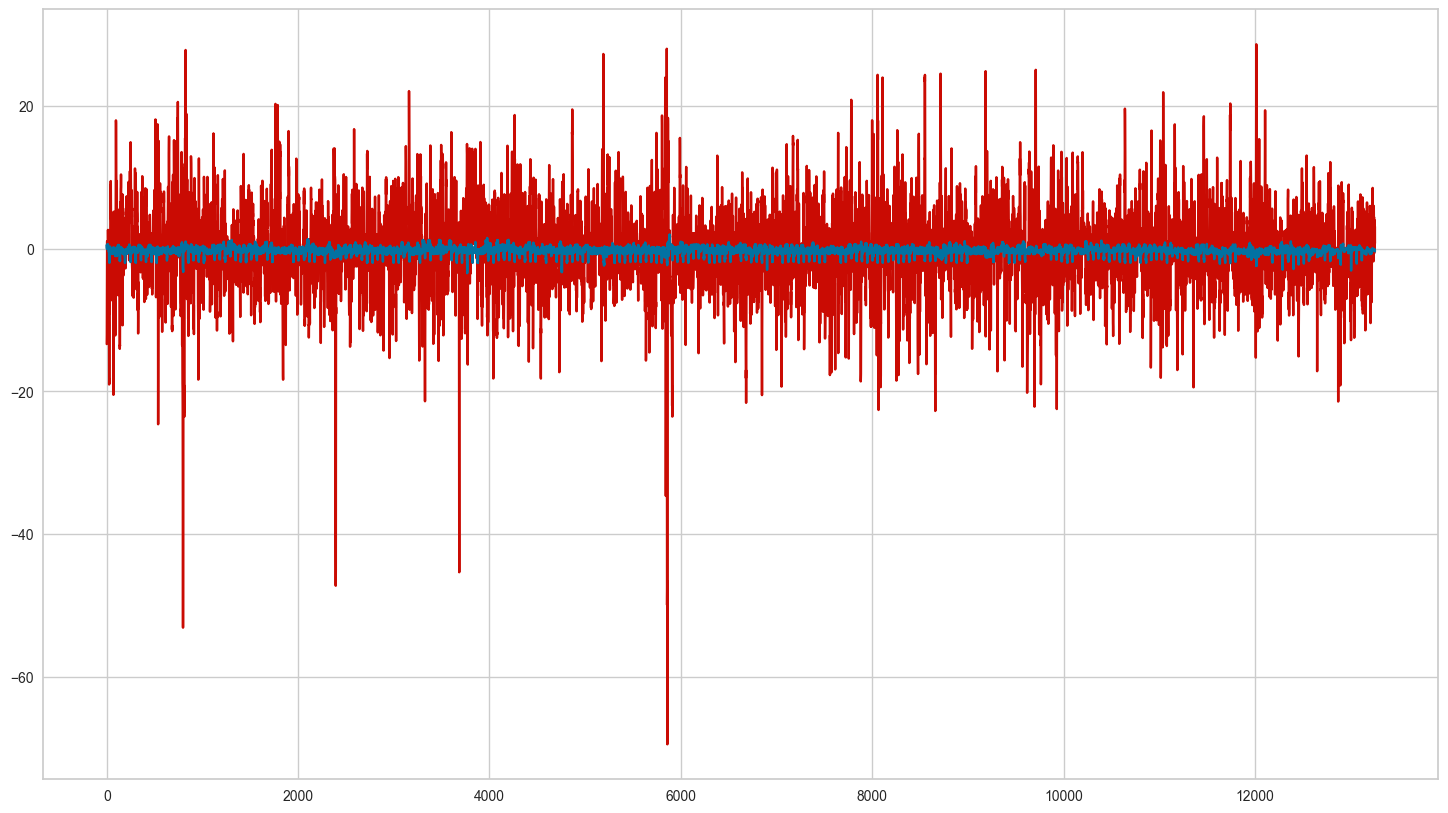

In [668]:
plt.figure(figsize=(18,10))
plt.plot(y_test,'r');
plt.plot(gb_bs.predict(X_test_sin_estandarizar),'b');

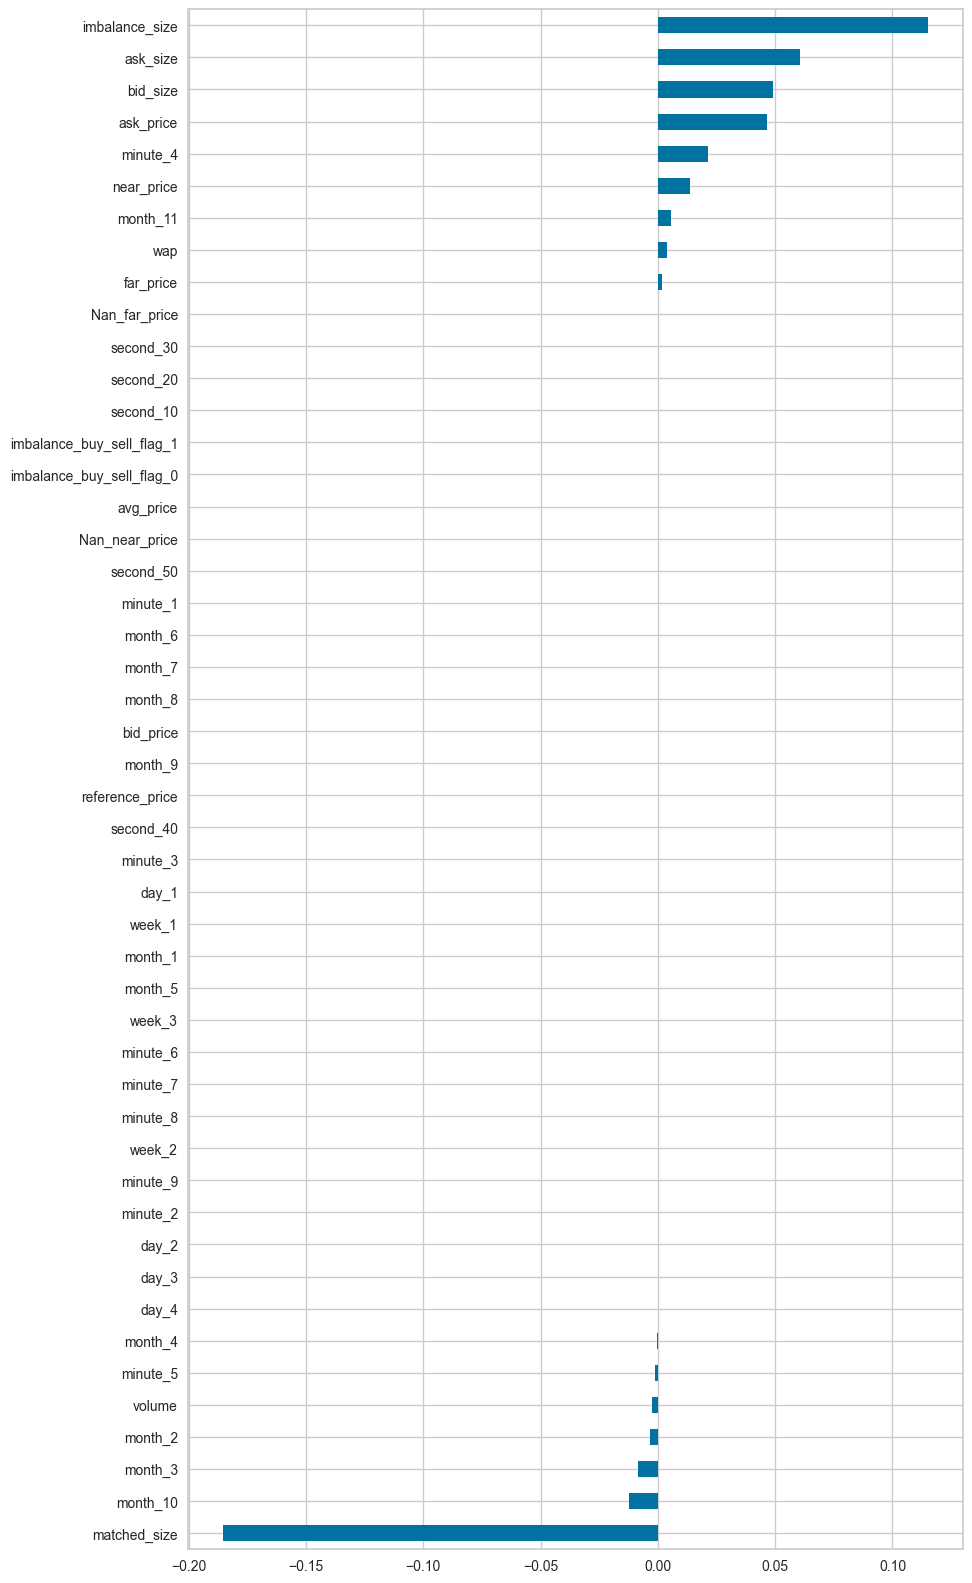

In [669]:
pi = permutation_importance(gb_bs,X_test_sin_estandarizar, y_test, n_jobs=-1, random_state=0)
var_imp_dt = pd.DataFrame({'importance': pi.importances_mean}, index=X_test.columns)
var_imp_dt.sort_values(by='importance').plot.barh(figsize=(10,20), legend=False);